In [ ]:
import ee
import pandas as pd
import os
from datetime import datetime

# Initialize Earth Engine
ee.Initialize()

# Directory containing CSV files
input_dir = "Katihar/Katihar_Chunks/"
output_dir = "Katihar/Processed/"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define start and end dates
startDate = ee.Date('2021-04-01')
endDate = ee.Date('2021-09-30')
daysStep = 5
nSteps = endDate.difference(startDate, 'day').divide(daysStep).ceil().int()

# Create date ranges
def create_date_range(n):
    n = ee.Number(n)
    return ee.Dictionary({
        'start': startDate.advance(n.multiply(daysStep), 'day'),
        'end': startDate.advance(n.multiply(daysStep).add(daysStep), 'day')
    })

results = ee.List.sequence(0, nSteps.subtract(1)).map(create_date_range)

# Sentinel-2 NDVI calculation
s2 = ee.ImageCollection('COPERNICUS/S2')
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

s2 = s2.map(add_ndvi)

# Function to check if Sentinel-2 data is available
def check_data_availability(point, start, end):
    filtered = s2.filterDate(start, end).filterBounds(point)
    count = filtered.size().getInfo()
    return count > 0  # True if images exist, False otherwise

# Function to sample NDVI values
def sample_ndvi(step, point):
    start = ee.Date(step.get('start'))
    end = ee.Date(step.get('end'))
    filtered = s2.filterDate(start, end).filterBounds(point)

    # Compute NDVI
    ndvi_image = filtered.mean().addBands(filtered.mean().normalizedDifference(['B8', 'B4']).rename('NDVI'))

    # Reduce region
    ndvi_value = ndvi_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=10,
        bestEffort=True
    ).get('NDVI')

    return ee.Algorithms.If(ndvi_value, ndvi_value, -9999)  # Return -9999 if NDVI is missing

# Process each CSV file
for file_name in os.listdir(input_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name)

        print(f"Processing {file_name}...")

        # Load CSV
        data = pd.read_csv(file_path)
        ndvi_timeseries = []

        # Process each row
        for idx, row in data.iterrows():
            lat, lon = row['Latitude'], row['Longitude']
            print(f'  Latitude: {lat}, Longitude: {lon}')
            point = ee.Geometry.Point(lon, lat)

            # Check if data exists
            if not check_data_availability(point, startDate, endDate):
                print(f"  No Sentinel-2 data for {lat}, {lon}. Skipping...")
                ndvi_values = [-9999] * nSteps.getInfo()
            else:
                try:
                    ndvi_values = results.map(lambda step: sample_ndvi(ee.Dictionary(step), point)).getInfo()
                except Exception as e:
                    print(f"  Error processing {lat}, {lon}: {e}")
                    ndvi_values = [-9999] * nSteps.getInfo()

            ndvi_timeseries.append(ndvi_values)

        # Store NDVI values and retain metadata
        data['NDVI_TimeSeries'] = ndvi_timeseries

        # Save the output
        data.to_csv(output_path, index=False)
        print(f"Saved results to {output_path}\n")

print("Processing completed for all CSV files.")


C:\Users\prath\anaconda3\Lib\site-packages\ee\deprecation.py:202: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Processing Katihar_1.csv...
  Latitude: 25.38320091, Longitude: 87.6794794
  Latitude: 25.38320091, Longitude: 87.67956923
  Latitude: 25.38320091, Longitude: 87.67965906
  Latitude: 25.38320091, Longitude: 87.6797489
  Latitude: 25.38320091, Longitude: 87.67983873
  Latitude: 25.38320091, Longitude: 87.67992856
  Latitude: 25.38320091, Longitude: 87.68001839
  Latitude: 25.38320091, Longitude: 87.68010822
  Latitude: 25.38320091, Longitude: 87.68019805
  Latitude: 25.38320091, Longitude: 87.68028789
  Latitude: 25.38320091, Longitude: 87.68037772
  Latitude: 25.38320091, Longitude: 87.68046755
  Latitude: 25.38320091, Longitude: 87.73194101
  Latitude: 25.38320091, Longitude: 87.73203085
  Latitude: 25.38320091, Longitude: 87.73212068
  Latitude: 25.38320091, Longitude: 87.73221051
  Latitude: 25.38320091, Longitude: 87.73230034
  Latitude: 25.38329074, Longitude: 87.6794794
  Latitude: 25.38329074, Longitude: 87.67956923
  Latitude: 25.38329074, Longitude: 87.67965906
  Latitude: 25.

  Latitude: 25.38841114, Longitude: 87.72888674
  Latitude: 25.38841114, Longitude: 87.72897657
  Latitude: 25.38841114, Longitude: 87.72960539
  Latitude: 25.38841114, Longitude: 87.72969523
  Latitude: 25.38841114, Longitude: 87.72978506
  Latitude: 25.38841114, Longitude: 87.72987489
  Latitude: 25.38850097, Longitude: 87.72825792
  Latitude: 25.38850097, Longitude: 87.72834775
  Latitude: 25.38850097, Longitude: 87.72843758
  Latitude: 25.38850097, Longitude: 87.72852742
  Latitude: 25.38850097, Longitude: 87.72861725
  Latitude: 25.38850097, Longitude: 87.72870708
  Latitude: 25.38850097, Longitude: 87.72879691
  Latitude: 25.38850097, Longitude: 87.72888674
  Latitude: 25.38850097, Longitude: 87.72897657
  Latitude: 25.38850097, Longitude: 87.72906641
  Latitude: 25.38850097, Longitude: 87.72951556
  Latitude: 25.38850097, Longitude: 87.72960539
  Latitude: 25.38850097, Longitude: 87.72969523
  Latitude: 25.38850097, Longitude: 87.72978506
  Latitude: 25.38850097, Longitude: 87.7

  Latitude: 25.43386589, Longitude: 87.69555925
  Latitude: 25.43395572, Longitude: 87.69537958
  Latitude: 25.43395572, Longitude: 87.69546941
  Latitude: 25.43395572, Longitude: 87.69555925
  Latitude: 25.43404556, Longitude: 87.69546941
  Latitude: 25.43404556, Longitude: 87.69555925
  Latitude: 25.43413539, Longitude: 87.69546941
  Latitude: 25.43413539, Longitude: 87.69555925
  Latitude: 25.43413539, Longitude: 87.69564908
  Latitude: 25.43413539, Longitude: 87.69573891
  Latitude: 25.43422522, Longitude: 87.69546941
  Latitude: 25.43422522, Longitude: 87.69555925
  Latitude: 25.43422522, Longitude: 87.69564908
  Latitude: 25.43422522, Longitude: 87.69573891
  Latitude: 25.43431505, Longitude: 87.69546941
  Latitude: 25.43431505, Longitude: 87.69555925
  Latitude: 25.43431505, Longitude: 87.69564908
  Latitude: 25.43431505, Longitude: 87.69573891
  Latitude: 25.43440488, Longitude: 87.69555925
  Latitude: 25.43440488, Longitude: 87.69564908
  Latitude: 25.43440488, Longitude: 87.6

  Latitude: 25.43871679, Longitude: 87.69924234
  Latitude: 25.43871679, Longitude: 87.69933217
  Latitude: 25.43871679, Longitude: 87.699422
  Latitude: 25.43871679, Longitude: 87.69951183
  Latitude: 25.43871679, Longitude: 87.69960166
  Latitude: 25.43871679, Longitude: 87.6996915
  Latitude: 25.43871679, Longitude: 87.69978133
  Latitude: 25.43871679, Longitude: 87.69987116
  Latitude: 25.43880663, Longitude: 87.69870335
  Latitude: 25.43880663, Longitude: 87.69879318
  Latitude: 25.43880663, Longitude: 87.69888301
  Latitude: 25.43880663, Longitude: 87.69897284
  Latitude: 25.43880663, Longitude: 87.69906267
  Latitude: 25.43880663, Longitude: 87.69915251
  Latitude: 25.43880663, Longitude: 87.69924234
  Latitude: 25.43880663, Longitude: 87.69933217
  Latitude: 25.43880663, Longitude: 87.699422
  Latitude: 25.43880663, Longitude: 87.69951183
  Latitude: 25.43880663, Longitude: 87.69960166
  Latitude: 25.43889646, Longitude: 87.69870335
  Latitude: 25.43889646, Longitude: 87.698793

  Latitude: 25.46611541, Longitude: 87.71262724
  Latitude: 25.46611541, Longitude: 87.71271707
  Latitude: 25.46620524, Longitude: 87.71020178
  Latitude: 25.46620524, Longitude: 87.71029162
  Latitude: 25.46620524, Longitude: 87.71038145
  Latitude: 25.46620524, Longitude: 87.71047128
  Latitude: 25.46620524, Longitude: 87.71056111
  Latitude: 25.46620524, Longitude: 87.71065094
  Latitude: 25.46620524, Longitude: 87.71074077
  Latitude: 25.46620524, Longitude: 87.7108306
  Latitude: 25.46620524, Longitude: 87.71092044
  Latitude: 25.46620524, Longitude: 87.71101027
  Latitude: 25.46620524, Longitude: 87.71145943
  Latitude: 25.46620524, Longitude: 87.71154926
  Latitude: 25.46620524, Longitude: 87.71163909
  Latitude: 25.46620524, Longitude: 87.71172892
  Latitude: 25.46620524, Longitude: 87.71226791
  Latitude: 25.46620524, Longitude: 87.71235774
  Latitude: 25.46620524, Longitude: 87.71244757
  Latitude: 25.46620524, Longitude: 87.7125374
  Latitude: 25.46620524, Longitude: 87.712

  Latitude: 25.46692389, Longitude: 87.71038145
  Latitude: 25.46692389, Longitude: 87.71047128
  Latitude: 25.43036246, Longitude: 87.23086075
  Latitude: 25.43036246, Longitude: 87.23095058
  Latitude: 25.43036246, Longitude: 87.23104041
  Latitude: 25.43045229, Longitude: 87.23077092
  Latitude: 25.43045229, Longitude: 87.23086075
  Latitude: 25.43045229, Longitude: 87.23095058
  Latitude: 25.43045229, Longitude: 87.23104041
  Latitude: 25.43045229, Longitude: 87.23113024
  Latitude: 25.43045229, Longitude: 87.23122007
  Latitude: 25.43045229, Longitude: 87.23130991
  Latitude: 25.43045229, Longitude: 87.23139974
  Latitude: 25.43054213, Longitude: 87.23077092
  Latitude: 25.43054213, Longitude: 87.23086075
  Latitude: 25.43054213, Longitude: 87.23095058
  Latitude: 25.43054213, Longitude: 87.23104041
  Latitude: 25.43054213, Longitude: 87.23113024
  Latitude: 25.43054213, Longitude: 87.23122007
  Latitude: 25.43054213, Longitude: 87.23130991
  Latitude: 25.43054213, Longitude: 87.2

  Latitude: 25.43889646, Longitude: 87.22942344
  Latitude: 25.43898629, Longitude: 87.22906412
  Latitude: 25.43898629, Longitude: 87.22915395
  Latitude: 25.43898629, Longitude: 87.22924378
  Latitude: 25.43898629, Longitude: 87.22933361
  Latitude: 25.43907612, Longitude: 87.22906412
  Latitude: 25.43907612, Longitude: 87.22915395
  Latitude: 25.43907612, Longitude: 87.22924378
  Latitude: 25.43907612, Longitude: 87.22933361
  Latitude: 25.43916595, Longitude: 87.22906412
  Latitude: 25.43916595, Longitude: 87.22915395
  Latitude: 25.43916595, Longitude: 87.22924378
  Latitude: 25.43916595, Longitude: 87.22933361
  Latitude: 25.43925578, Longitude: 87.22906412
  Latitude: 25.43925578, Longitude: 87.22915395
  Latitude: 25.43925578, Longitude: 87.22924378
  Latitude: 25.43925578, Longitude: 87.22933361
  Latitude: 25.43934562, Longitude: 87.22906412
  Latitude: 25.43934562, Longitude: 87.22915395
  Latitude: 25.43934562, Longitude: 87.22924378
  Latitude: 25.43934562, Longitude: 87.2

  Latitude: 25.48183593, Longitude: 87.3840235
  Latitude: 25.48183593, Longitude: 87.38447266
  Latitude: 25.48183593, Longitude: 87.38456249
  Latitude: 25.48192576, Longitude: 87.38357435
  Latitude: 25.48192576, Longitude: 87.38366418
  Latitude: 25.48192576, Longitude: 87.38375401
  Latitude: 25.48192576, Longitude: 87.38384384
  Latitude: 25.48192576, Longitude: 87.38393367
  Latitude: 25.48192576, Longitude: 87.3840235
  Latitude: 25.48201559, Longitude: 87.38276586
  Latitude: 25.48201559, Longitude: 87.38375401
  Latitude: 25.48201559, Longitude: 87.38384384
  Latitude: 25.48201559, Longitude: 87.38393367
  Latitude: 25.48201559, Longitude: 87.3840235
  Latitude: 25.48210542, Longitude: 87.38276586
  Latitude: 25.48210542, Longitude: 87.38285569
  Latitude: 25.48210542, Longitude: 87.38294553
  Latitude: 25.48210542, Longitude: 87.38303536
  Latitude: 25.48210542, Longitude: 87.38312519
  Latitude: 25.48210542, Longitude: 87.38321502
  Latitude: 25.48210542, Longitude: 87.3833

  Latitude: 25.49522083, Longitude: 87.41294926
  Latitude: 25.49522083, Longitude: 87.41303909
  Latitude: 25.49522083, Longitude: 87.41312892
  Latitude: 25.49522083, Longitude: 87.41321875
  Latitude: 25.49522083, Longitude: 87.41348825
  Latitude: 25.49522083, Longitude: 87.41357808
  Latitude: 25.49522083, Longitude: 87.41366791
  Latitude: 25.49522083, Longitude: 87.41375774
  Latitude: 25.49522083, Longitude: 87.41384757
  Latitude: 25.49522083, Longitude: 87.4139374
  Latitude: 25.49522083, Longitude: 87.41402724
  Latitude: 25.49522083, Longitude: 87.41411707
  Latitude: 25.49522083, Longitude: 87.4142069
  Latitude: 25.49522083, Longitude: 87.41429673
  Latitude: 25.49522083, Longitude: 87.41438656
  Latitude: 25.49531066, Longitude: 87.4125001
  Latitude: 25.49531066, Longitude: 87.41258993
  Latitude: 25.49531066, Longitude: 87.41267976
  Latitude: 25.49531066, Longitude: 87.41276959
  Latitude: 25.49531066, Longitude: 87.41285943
  Latitude: 25.49531066, Longitude: 87.4134

  Latitude: 25.50114971, Longitude: 87.41492555
  Latitude: 25.50114971, Longitude: 87.41501538
  Latitude: 25.50123954, Longitude: 87.41411707
  Latitude: 25.50123954, Longitude: 87.4142069
  Latitude: 25.50123954, Longitude: 87.41429673
  Latitude: 25.50123954, Longitude: 87.41438656
  Latitude: 25.50123954, Longitude: 87.41474589
  Latitude: 25.50123954, Longitude: 87.41483572
  Latitude: 25.50123954, Longitude: 87.41492555
  Latitude: 25.50123954, Longitude: 87.41501538
  Latitude: 25.50132937, Longitude: 87.41366791
  Latitude: 25.50132937, Longitude: 87.41375774
  Latitude: 25.50132937, Longitude: 87.41384757
  Latitude: 25.50132937, Longitude: 87.4139374
  Latitude: 25.50132937, Longitude: 87.41402724
  Latitude: 25.50132937, Longitude: 87.41411707
  Latitude: 25.50132937, Longitude: 87.4142069
  Latitude: 25.50132937, Longitude: 87.41429673
  Latitude: 25.50132937, Longitude: 87.41438656
  Latitude: 25.50132937, Longitude: 87.41474589
  Latitude: 25.50132937, Longitude: 87.4148

  Latitude: 25.50734808, Longitude: 87.41178145
  Latitude: 25.50734808, Longitude: 87.41187128
  Latitude: 25.50734808, Longitude: 87.41196111
  Latitude: 25.50743791, Longitude: 87.41124246
  Latitude: 25.50743791, Longitude: 87.41133229
  Latitude: 25.50743791, Longitude: 87.41142212
  Latitude: 25.50743791, Longitude: 87.41151195
  Latitude: 25.50743791, Longitude: 87.41160178
  Latitude: 25.50743791, Longitude: 87.41169162
  Latitude: 25.50743791, Longitude: 87.41178145
  Latitude: 25.50752775, Longitude: 87.41124246
  Latitude: 25.50752775, Longitude: 87.41133229
  Latitude: 25.50752775, Longitude: 87.41142212
  Latitude: 25.50752775, Longitude: 87.41151195
  Latitude: 25.50752775, Longitude: 87.41160178
  Latitude: 25.50752775, Longitude: 87.41169162
  Latitude: 25.50752775, Longitude: 87.41178145
  Latitude: 25.50761758, Longitude: 87.41151195
  Latitude: 25.50761758, Longitude: 87.41160178
  Latitude: 25.50761758, Longitude: 87.41169162
  Latitude: 25.50761758, Longitude: 87.4

  Latitude: 25.51085151, Longitude: 87.40962549
  Latitude: 25.51085151, Longitude: 87.40971532
  Latitude: 25.51085151, Longitude: 87.40980515
  Latitude: 25.51085151, Longitude: 87.41007465
  Latitude: 25.51085151, Longitude: 87.41016448
  Latitude: 25.51085151, Longitude: 87.41025431
  Latitude: 25.51085151, Longitude: 87.41034414
  Latitude: 25.51085151, Longitude: 87.41043397
  Latitude: 25.51085151, Longitude: 87.41052381
  Latitude: 25.51085151, Longitude: 87.41061364
  Latitude: 25.51085151, Longitude: 87.41070347
  Latitude: 25.51085151, Longitude: 87.4107933
  Latitude: 25.51085151, Longitude: 87.41088313
  Latitude: 25.51085151, Longitude: 87.41097296
  Latitude: 25.51094134, Longitude: 87.40702038
  Latitude: 25.51094134, Longitude: 87.40711021
  Latitude: 25.51094134, Longitude: 87.40720004
  Latitude: 25.51094134, Longitude: 87.40926616
  Latitude: 25.51094134, Longitude: 87.409356
  Latitude: 25.51094134, Longitude: 87.40944583
  Latitude: 25.51094134, Longitude: 87.4095

  Latitude: 25.52836866, Longitude: 87.40666105
  Latitude: 25.52836866, Longitude: 87.40675088
  Latitude: 25.52836866, Longitude: 87.40684071
  Latitude: 25.52836866, Longitude: 87.40693054
  Latitude: 25.52845849, Longitude: 87.40648139
  Latitude: 25.52845849, Longitude: 87.40657122
  Latitude: 25.52845849, Longitude: 87.40666105
  Latitude: 25.52845849, Longitude: 87.40675088
  Latitude: 25.52845849, Longitude: 87.40684071
  Latitude: 25.52854832, Longitude: 87.40648139
  Latitude: 25.52854832, Longitude: 87.40657122
  Latitude: 25.52854832, Longitude: 87.40666105
  Latitude: 25.52854832, Longitude: 87.40675088
  Latitude: 25.52854832, Longitude: 87.40684071
  Latitude: 25.52863815, Longitude: 87.40648139
  Latitude: 25.52863815, Longitude: 87.40657122
  Latitude: 25.52863815, Longitude: 87.40666105
  Latitude: 25.52863815, Longitude: 87.40675088
  Latitude: 25.52863815, Longitude: 87.40684071
  Latitude: 25.52872799, Longitude: 87.40648139
  Latitude: 25.52872799, Longitude: 87.4

  Latitude: 25.50249718, Longitude: 87.69394228
  Latitude: 25.50249718, Longitude: 87.69403211
  Latitude: 25.50249718, Longitude: 87.69412194
  Latitude: 25.50249718, Longitude: 87.69421177
  Latitude: 25.50258701, Longitude: 87.69376261
  Latitude: 25.50258701, Longitude: 87.69385245
  Latitude: 25.50258701, Longitude: 87.69394228
  Latitude: 25.50258701, Longitude: 87.69403211
  Latitude: 25.50258701, Longitude: 87.69412194
  Latitude: 25.50258701, Longitude: 87.69421177
  Latitude: 25.50267684, Longitude: 87.69367278
  Latitude: 25.50267684, Longitude: 87.69376261
  Latitude: 25.50267684, Longitude: 87.69385245
  Latitude: 25.50267684, Longitude: 87.69394228
  Latitude: 25.50267684, Longitude: 87.69403211
  Latitude: 25.50267684, Longitude: 87.69412194
  Latitude: 25.50267684, Longitude: 87.69421177
  Latitude: 25.50276667, Longitude: 87.69367278
  Latitude: 25.50276667, Longitude: 87.69376261
  Latitude: 25.50276667, Longitude: 87.69385245
  Latitude: 25.50276667, Longitude: 87.6

  Latitude: 25.54112474, Longitude: 87.69187615
  Latitude: 25.54112474, Longitude: 87.69196598
  Latitude: 25.54112474, Longitude: 87.69205582
  Latitude: 25.54121457, Longitude: 87.69142699
  Latitude: 25.54121457, Longitude: 87.69151683
  Latitude: 25.54121457, Longitude: 87.69160666
  Latitude: 25.54121457, Longitude: 87.69169649
  Latitude: 25.54121457, Longitude: 87.69178632
  Latitude: 25.54121457, Longitude: 87.69187615
  Latitude: 25.54121457, Longitude: 87.69196598
  Latitude: 25.54121457, Longitude: 87.69205582
  Latitude: 25.5413044, Longitude: 87.69151683
  Latitude: 25.5413044, Longitude: 87.69160666
  Latitude: 25.5413044, Longitude: 87.69169649
  Latitude: 25.5413044, Longitude: 87.69178632
  Latitude: 25.5413044, Longitude: 87.69187615
  Latitude: 25.5413044, Longitude: 87.69196598
  Latitude: 25.5413044, Longitude: 87.69205582
  Latitude: 25.54139423, Longitude: 87.69151683
  Latitude: 25.54202305, Longitude: 87.74325979
  Latitude: 25.54202305, Longitude: 87.74334962

  Latitude: 25.51417528, Longitude: 87.53943205
  Latitude: 25.51426511, Longitude: 87.53925239
  Latitude: 25.51426511, Longitude: 87.53934222
  Latitude: 25.51426511, Longitude: 87.53943205
  Latitude: 25.51435494, Longitude: 87.53925239
  Latitude: 25.51435494, Longitude: 87.53934222
  Latitude: 25.51435494, Longitude: 87.53943205
  Latitude: 25.51444477, Longitude: 87.53925239
  Latitude: 25.51444477, Longitude: 87.53934222
  Latitude: 25.51444477, Longitude: 87.53943205
  Latitude: 25.5145346, Longitude: 87.5387134
  Latitude: 25.5145346, Longitude: 87.53880323
  Latitude: 25.5145346, Longitude: 87.53889306
  Latitude: 25.5145346, Longitude: 87.53898289
  Latitude: 25.5145346, Longitude: 87.53907272
  Latitude: 25.5145346, Longitude: 87.53916255
  Latitude: 25.5145346, Longitude: 87.53925239
  Latitude: 25.51462444, Longitude: 87.53862357
  Latitude: 25.51462444, Longitude: 87.5387134
  Latitude: 25.51462444, Longitude: 87.53880323
  Latitude: 25.51462444, Longitude: 87.53889306
 

  Latitude: 25.51561258, Longitude: 87.53934222
  Latitude: 25.51561258, Longitude: 87.53943205
  Latitude: 25.51561258, Longitude: 87.53952188
  Latitude: 25.51561258, Longitude: 87.5404202
  Latitude: 25.51561258, Longitude: 87.54051003
  Latitude: 25.51561258, Longitude: 87.54059986
  Latitude: 25.51561258, Longitude: 87.54068969
  Latitude: 25.51561258, Longitude: 87.54383379
  Latitude: 25.51561258, Longitude: 87.54392363
  Latitude: 25.51561258, Longitude: 87.54401346
  Latitude: 25.51561258, Longitude: 87.54410329
  Latitude: 25.51561258, Longitude: 87.54419312
  Latitude: 25.51570241, Longitude: 87.5384439
  Latitude: 25.51570241, Longitude: 87.53853373
  Latitude: 25.51570241, Longitude: 87.53862357
  Latitude: 25.51570241, Longitude: 87.5387134
  Latitude: 25.51570241, Longitude: 87.53880323
  Latitude: 25.51570241, Longitude: 87.53889306
  Latitude: 25.51570241, Longitude: 87.53898289
  Latitude: 25.51570241, Longitude: 87.53907272
  Latitude: 25.51570241, Longitude: 87.5391

  Latitude: 25.51696006, Longitude: 87.53979137
  Latitude: 25.51696006, Longitude: 87.53988121
  Latitude: 25.51696006, Longitude: 87.53997104
  Latitude: 25.5182177, Longitude: 87.51284192
  Latitude: 25.5182177, Longitude: 87.51293175
  Latitude: 25.5182177, Longitude: 87.51302158
  Latitude: 25.5182177, Longitude: 87.51311141
  Latitude: 25.51830753, Longitude: 87.51248259
  Latitude: 25.51830753, Longitude: 87.51257242
  Latitude: 25.51830753, Longitude: 87.51266225
  Latitude: 25.51830753, Longitude: 87.51275208
  Latitude: 25.51830753, Longitude: 87.51284192
  Latitude: 25.51830753, Longitude: 87.51293175
  Latitude: 25.51830753, Longitude: 87.51302158
  Latitude: 25.51830753, Longitude: 87.51311141
  Latitude: 25.51830753, Longitude: 87.51320124
  Latitude: 25.51839736, Longitude: 87.5119436
  Latitude: 25.51839736, Longitude: 87.51203343
  Latitude: 25.51839736, Longitude: 87.51212326
  Latitude: 25.51839736, Longitude: 87.5122131
  Latitude: 25.51839736, Longitude: 87.5123029

  Latitude: 25.52073298, Longitude: 87.50772152
  Latitude: 25.52073298, Longitude: 87.50781135
  Latitude: 25.52073298, Longitude: 87.50790118
  Latitude: 25.52082281, Longitude: 87.50583506
  Latitude: 25.52082281, Longitude: 87.50592489
  Latitude: 25.52082281, Longitude: 87.50601472
  Latitude: 25.52082281, Longitude: 87.50610455
  Latitude: 25.52082281, Longitude: 87.50619438
  Latitude: 25.52082281, Longitude: 87.50628421
  Latitude: 25.52082281, Longitude: 87.50637405
  Latitude: 25.52082281, Longitude: 87.50736219
  Latitude: 25.52082281, Longitude: 87.50745202
  Latitude: 25.52082281, Longitude: 87.50754186
  Latitude: 25.52082281, Longitude: 87.50763169
  Latitude: 25.52082281, Longitude: 87.50772152
  Latitude: 25.52082281, Longitude: 87.50781135
  Latitude: 25.52082281, Longitude: 87.50790118
  Latitude: 25.52091264, Longitude: 87.50583506
  Latitude: 25.52091264, Longitude: 87.50592489
  Latitude: 25.52091264, Longitude: 87.50601472
  Latitude: 25.52091264, Longitude: 87.5

  Latitude: 25.52234995, Longitude: 87.49900786
  Latitude: 25.52234995, Longitude: 87.49909769
  Latitude: 25.52234995, Longitude: 87.49918752
  Latitude: 25.52234995, Longitude: 87.49927736
  Latitude: 25.52234995, Longitude: 87.49936719
  Latitude: 25.52234995, Longitude: 87.51257242
  Latitude: 25.52234995, Longitude: 87.51266225
  Latitude: 25.52234995, Longitude: 87.51275208
  Latitude: 25.52234995, Longitude: 87.51284192
  Latitude: 25.52234995, Longitude: 87.51293175
  Latitude: 25.52234995, Longitude: 87.51302158
  Latitude: 25.52234995, Longitude: 87.51311141
  Latitude: 25.52243978, Longitude: 87.49819938
  Latitude: 25.52243978, Longitude: 87.49828921
  Latitude: 25.52243978, Longitude: 87.49837904
  Latitude: 25.52243978, Longitude: 87.49846887
  Latitude: 25.52243978, Longitude: 87.4985587
  Latitude: 25.52243978, Longitude: 87.49864853
  Latitude: 25.52243978, Longitude: 87.49873837
  Latitude: 25.52243978, Longitude: 87.4988282
  Latitude: 25.52243978, Longitude: 87.498

  Latitude: 25.54480783, Longitude: 87.54769655
  Latitude: 25.54480783, Longitude: 87.54778638
  Latitude: 25.54480783, Longitude: 87.54787621
  Latitude: 25.54480783, Longitude: 87.54796604
  Latitude: 25.54480783, Longitude: 87.54805588
  Latitude: 25.54480783, Longitude: 87.54814571
  Latitude: 25.54489766, Longitude: 87.54742705
  Latitude: 25.54489766, Longitude: 87.54751689
  Latitude: 25.54489766, Longitude: 87.54760672
  Latitude: 25.54489766, Longitude: 87.54769655
  Latitude: 25.54489766, Longitude: 87.54778638
  Latitude: 25.54489766, Longitude: 87.54787621
  Latitude: 25.54489766, Longitude: 87.54796604
  Latitude: 25.54489766, Longitude: 87.54805588
  Latitude: 25.54498749, Longitude: 87.54742705
  Latitude: 25.54498749, Longitude: 87.54751689
  Latitude: 25.54498749, Longitude: 87.54760672
  Latitude: 25.54498749, Longitude: 87.54769655
  Latitude: 25.54498749, Longitude: 87.54778638
  Latitude: 25.54498749, Longitude: 87.54787621
  Latitude: 25.54498749, Longitude: 87.5

  Latitude: 25.54885025, Longitude: 87.53808458
  Latitude: 25.54885025, Longitude: 87.53817441
  Latitude: 25.54885025, Longitude: 87.53826424
  Latitude: 25.54885025, Longitude: 87.53835407
  Latitude: 25.54894008, Longitude: 87.53790491
  Latitude: 25.54894008, Longitude: 87.53799474
  Latitude: 25.54894008, Longitude: 87.53808458
  Latitude: 25.54894008, Longitude: 87.53817441
  Latitude: 25.54894008, Longitude: 87.53826424
  Latitude: 25.54894008, Longitude: 87.53835407
  Latitude: 25.29714231, Longitude: 87.77002958
  Latitude: 25.29714231, Longitude: 87.77011941
  Latitude: 25.29714231, Longitude: 87.77020925
  Latitude: 25.29723214, Longitude: 87.76949059
  Latitude: 25.29723214, Longitude: 87.76958042
  Latitude: 25.29723214, Longitude: 87.76967026
  Latitude: 25.29723214, Longitude: 87.76976009
  Latitude: 25.29723214, Longitude: 87.76984992
  Latitude: 25.29723214, Longitude: 87.76993975
  Latitude: 25.29723214, Longitude: 87.77002958
  Latitude: 25.29723214, Longitude: 87.7

  Latitude: 25.30828142, Longitude: 87.77398217
  Latitude: 25.30828142, Longitude: 87.774072
  Latitude: 25.30828142, Longitude: 87.77416183
  Latitude: 25.30837125, Longitude: 87.77398217
  Latitude: 25.30837125, Longitude: 87.774072
  Latitude: 25.30837125, Longitude: 87.77416183
  Latitude: 25.31780356, Longitude: 87.77766526
  Latitude: 25.31780356, Longitude: 87.77775509
  Latitude: 25.31780356, Longitude: 87.77784493
  Latitude: 25.31780356, Longitude: 87.77793476
  Latitude: 25.31789339, Longitude: 87.77757543
  Latitude: 25.31789339, Longitude: 87.77766526
  Latitude: 25.31789339, Longitude: 87.77775509
  Latitude: 25.31789339, Longitude: 87.77784493
  Latitude: 25.31789339, Longitude: 87.77793476
  Latitude: 25.31798322, Longitude: 87.7774856
  Latitude: 25.31798322, Longitude: 87.77757543
  Latitude: 25.31798322, Longitude: 87.77766526
  Latitude: 25.31798322, Longitude: 87.77775509
  Latitude: 25.31807305, Longitude: 87.77766526
  Latitude: 25.31807305, Longitude: 87.777755

  Latitude: 25.54076541, Longitude: 87.93684673
  Latitude: 25.54085524, Longitude: 87.93639757
  Latitude: 25.54085524, Longitude: 87.9364874
  Latitude: 25.54085524, Longitude: 87.93657724
  Latitude: 25.552713, Longitude: 87.9897575
  Latitude: 25.552713, Longitude: 87.98984733
  Latitude: 25.55280284, Longitude: 87.98966767
  Latitude: 25.55280284, Longitude: 87.9897575
  Latitude: 25.55280284, Longitude: 87.98984733
  Latitude: 25.55289267, Longitude: 87.98966767
  Latitude: 25.55289267, Longitude: 87.9897575
  Latitude: 25.55289267, Longitude: 87.98984733
  Latitude: 25.55289267, Longitude: 87.98993716
  Latitude: 25.5529825, Longitude: 87.9897575
  Latitude: 25.5529825, Longitude: 87.98984733
  Latitude: 25.55585711, Longitude: 87.99011683
  Latitude: 25.55585711, Longitude: 87.99020666
  Latitude: 25.55585711, Longitude: 87.99029649
  Latitude: 25.55585711, Longitude: 87.99038632
  Latitude: 25.55585711, Longitude: 87.99047615
  Latitude: 25.55585711, Longitude: 87.99056598
  L

  Latitude: 25.34475302, Longitude: 87.70014065
  Latitude: 25.34475302, Longitude: 87.70023048
  Latitude: 25.34484285, Longitude: 87.70014065
  Latitude: 25.34484285, Longitude: 87.70023048
  Latitude: 25.34493268, Longitude: 87.70014065
  Latitude: 25.34493268, Longitude: 87.70023048
  Latitude: 25.34502251, Longitude: 87.70014065
  Latitude: 25.34502251, Longitude: 87.70023048
  Latitude: 25.34933442, Longitude: 87.74963783
  Latitude: 25.34933442, Longitude: 87.74972766
  Latitude: 25.34933442, Longitude: 87.74981749
  Latitude: 25.34933442, Longitude: 87.74990732
  Latitude: 25.34933442, Longitude: 87.74999715
  Latitude: 25.34933442, Longitude: 87.75008698
  Latitude: 25.34933442, Longitude: 87.75044631
  Latitude: 25.34933442, Longitude: 87.75053614
  Latitude: 25.34933442, Longitude: 87.75062597
  Latitude: 25.34942426, Longitude: 87.74963783
  Latitude: 25.34942426, Longitude: 87.74972766
  Latitude: 25.34942426, Longitude: 87.74981749
  Latitude: 25.34942426, Longitude: 87.7

  Latitude: 25.35050223, Longitude: 87.699422
  Latitude: 25.35059207, Longitude: 87.69726604
  Latitude: 25.35059207, Longitude: 87.69735588
  Latitude: 25.35059207, Longitude: 87.69744571
  Latitude: 25.35059207, Longitude: 87.69753554
  Latitude: 25.35059207, Longitude: 87.69762537
  Latitude: 25.35059207, Longitude: 87.6977152
  Latitude: 25.35059207, Longitude: 87.69780503
  Latitude: 25.35059207, Longitude: 87.69789486
  Latitude: 25.35059207, Longitude: 87.6979847
  Latitude: 25.35059207, Longitude: 87.69816436
  Latitude: 25.35059207, Longitude: 87.69825419
  Latitude: 25.35059207, Longitude: 87.69834402
  Latitude: 25.35059207, Longitude: 87.69843385
  Latitude: 25.35059207, Longitude: 87.69852369
  Latitude: 25.35059207, Longitude: 87.69879318
  Latitude: 25.35059207, Longitude: 87.69888301
  Latitude: 25.35059207, Longitude: 87.69897284
  Latitude: 25.35059207, Longitude: 87.69906267
  Latitude: 25.35059207, Longitude: 87.69915251
  Latitude: 25.35059207, Longitude: 87.69924

  Latitude: 25.36218033, Longitude: 87.73427663
  Latitude: 25.36218033, Longitude: 87.73436647
  Latitude: 25.36218033, Longitude: 87.7344563
  Latitude: 25.36640241, Longitude: 87.73310882
  Latitude: 25.36640241, Longitude: 87.73319866
  Latitude: 25.36640241, Longitude: 87.73328849
  Latitude: 25.36640241, Longitude: 87.73337832
  Latitude: 25.36640241, Longitude: 87.73355798
  Latitude: 25.36640241, Longitude: 87.73364781
  Latitude: 25.36640241, Longitude: 87.73373764
  Latitude: 25.36649225, Longitude: 87.73310882
  Latitude: 25.36649225, Longitude: 87.73319866
  Latitude: 25.36649225, Longitude: 87.73328849
  Latitude: 25.36649225, Longitude: 87.73337832
  Latitude: 25.36649225, Longitude: 87.73355798
  Latitude: 25.36649225, Longitude: 87.73364781
  Latitude: 25.36649225, Longitude: 87.73373764
  Latitude: 25.36658208, Longitude: 87.73310882
  Latitude: 25.36658208, Longitude: 87.73319866
  Latitude: 25.36658208, Longitude: 87.73328849
  Latitude: 25.36658208, Longitude: 87.73

  Latitude: 25.38113478, Longitude: 87.72601213
  Latitude: 25.38113478, Longitude: 87.72610196
  Latitude: 25.38113478, Longitude: 87.7261918
  Latitude: 25.38113478, Longitude: 87.72628163
  Latitude: 25.38113478, Longitude: 87.72637146
  Latitude: 25.38113478, Longitude: 87.72646129
  Latitude: 25.38113478, Longitude: 87.72655112
  Latitude: 25.38113478, Longitude: 87.72664095
  Latitude: 25.38113478, Longitude: 87.72673079
  Latitude: 25.38113478, Longitude: 87.72682062
  Latitude: 25.38113478, Longitude: 87.72691045
  Latitude: 25.38113478, Longitude: 87.72700028
  Latitude: 25.38113478, Longitude: 87.72709011
  Latitude: 25.38113478, Longitude: 87.72717994
  Latitude: 25.38122462, Longitude: 87.7259223
  Latitude: 25.38122462, Longitude: 87.72601213
  Latitude: 25.38122462, Longitude: 87.72610196
  Latitude: 25.38122462, Longitude: 87.7261918
  Latitude: 25.38122462, Longitude: 87.72628163
  Latitude: 25.38122462, Longitude: 87.72637146
  Latitude: 25.38122462, Longitude: 87.7264

  Latitude: 25.47779351, Longitude: 87.76805329
  Latitude: 25.47779351, Longitude: 87.76814312
  Latitude: 25.47788334, Longitude: 87.76769396
  Latitude: 25.47788334, Longitude: 87.76778379
  Latitude: 25.47788334, Longitude: 87.76787363
  Latitude: 25.47788334, Longitude: 87.76796346
  Latitude: 25.47788334, Longitude: 87.76805329
  Latitude: 25.47788334, Longitude: 87.76814312
  Latitude: 25.47797317, Longitude: 87.76778379
  Latitude: 25.47797317, Longitude: 87.76787363
  Latitude: 25.47797317, Longitude: 87.76796346
  Latitude: 25.47797317, Longitude: 87.76805329
  Latitude: 25.478063, Longitude: 87.76778379
  Latitude: 25.478063, Longitude: 87.76787363
  Latitude: 25.47905115, Longitude: 87.79167898
  Latitude: 25.47905115, Longitude: 87.79176881
  Latitude: 25.47914098, Longitude: 87.79158915
  Latitude: 25.47914098, Longitude: 87.79167898
  Latitude: 25.47914098, Longitude: 87.79176881
  Latitude: 25.47923081, Longitude: 87.79158915
  Latitude: 25.47923081, Longitude: 87.79167

  Latitude: 25.52199062, Longitude: 87.83461845
  Latitude: 25.52199062, Longitude: 87.83470828
  Latitude: 25.52199062, Longitude: 87.83479811
  Latitude: 25.52199062, Longitude: 87.83488795
  Latitude: 25.52199062, Longitude: 87.83497778
  Latitude: 25.52199062, Longitude: 87.83506761
  Latitude: 25.52199062, Longitude: 87.83515744
  Latitude: 25.52208045, Longitude: 87.83461845
  Latitude: 25.52208045, Longitude: 87.83470828
  Latitude: 25.52208045, Longitude: 87.83479811
  Latitude: 25.52208045, Longitude: 87.83488795
  Latitude: 25.52208045, Longitude: 87.83497778
  Latitude: 25.52208045, Longitude: 87.83506761
Saved results to Katihar/Processed/Katihar_1.csv

Processing Katihar_10.csv...
  Latitude: 25.46476794, Longitude: 87.69699655
  Latitude: 25.46476794, Longitude: 87.69708638
  Latitude: 25.46485777, Longitude: 87.6960084
  Latitude: 25.46485777, Longitude: 87.69609823
  Latitude: 25.46485777, Longitude: 87.69618807
  Latitude: 25.46485777, Longitude: 87.6962779
  Latitude:

  Latitude: 25.46656457, Longitude: 87.71038145
  Latitude: 25.46656457, Longitude: 87.71047128
  Latitude: 25.46656457, Longitude: 87.71056111
  Latitude: 25.46656457, Longitude: 87.71065094
  Latitude: 25.46656457, Longitude: 87.71074077
  Latitude: 25.46656457, Longitude: 87.7108306
  Latitude: 25.46656457, Longitude: 87.71092044
  Latitude: 25.46656457, Longitude: 87.71101027
  Latitude: 25.46656457, Longitude: 87.7111001
  Latitude: 25.46656457, Longitude: 87.71118993
  Latitude: 25.46656457, Longitude: 87.71127976
  Latitude: 25.46656457, Longitude: 87.71136959
  Latitude: 25.46656457, Longitude: 87.71145943
  Latitude: 25.46656457, Longitude: 87.71154926
  Latitude: 25.46656457, Longitude: 87.71199841
  Latitude: 25.46656457, Longitude: 87.71208825
  Latitude: 25.46656457, Longitude: 87.71217808
  Latitude: 25.46656457, Longitude: 87.71226791
  Latitude: 25.46656457, Longitude: 87.71235774
  Latitude: 25.46656457, Longitude: 87.71289673
  Latitude: 25.46656457, Longitude: 87.712

  Latitude: 25.67003298, Longitude: 87.75368024
  Latitude: 25.67003298, Longitude: 87.75377008
  Latitude: 25.67003298, Longitude: 87.75385991
  Latitude: 25.67003298, Longitude: 87.75394974
  Latitude: 25.67003298, Longitude: 87.75403957
  Latitude: 25.67003298, Longitude: 87.7541294
  Latitude: 25.67003298, Longitude: 87.75421923
  Latitude: 25.67003298, Longitude: 87.77964156
  Latitude: 25.67003298, Longitude: 87.77973139
  Latitude: 25.67003298, Longitude: 87.77982122
  Latitude: 25.67003298, Longitude: 87.77991105
  Latitude: 25.67003298, Longitude: 87.78000088
  Latitude: 25.67003298, Longitude: 87.78009071
  Latitude: 25.67012281, Longitude: 87.75359041
  Latitude: 25.67012281, Longitude: 87.75368024
  Latitude: 25.67012281, Longitude: 87.75377008
  Latitude: 25.67012281, Longitude: 87.75385991
  Latitude: 25.67012281, Longitude: 87.75394974
  Latitude: 25.67012281, Longitude: 87.75403957
  Latitude: 25.67012281, Longitude: 87.7541294
  Latitude: 25.67012281, Longitude: 87.754

  Latitude: 25.68198057, Longitude: 87.82500648
  Latitude: 25.68198057, Longitude: 87.82509631
  Latitude: 25.68198057, Longitude: 87.82527597
  Latitude: 25.68198057, Longitude: 87.8253658
  Latitude: 25.6820704, Longitude: 87.82455732
  Latitude: 25.6820704, Longitude: 87.82464715
  Latitude: 25.6820704, Longitude: 87.82473698
  Latitude: 25.6820704, Longitude: 87.82482681
  Latitude: 25.6820704, Longitude: 87.82491665
  Latitude: 25.6820704, Longitude: 87.82500648
  Latitude: 25.6820704, Longitude: 87.82509631
  Latitude: 25.6820704, Longitude: 87.82518614
  Latitude: 25.6820704, Longitude: 87.82527597
  Latitude: 25.6820704, Longitude: 87.8253658
  Latitude: 25.68216024, Longitude: 87.82455732
  Latitude: 25.68216024, Longitude: 87.82464715
  Latitude: 25.68216024, Longitude: 87.82473698
  Latitude: 25.68216024, Longitude: 87.82482681
  Latitude: 25.68216024, Longitude: 87.82491665
  Latitude: 25.68216024, Longitude: 87.82500648
  Latitude: 25.68216024, Longitude: 87.82509631
  La

  Latitude: 25.70955885, Longitude: 87.8025486
  Latitude: 25.70955885, Longitude: 87.80263843
  Latitude: 25.70955885, Longitude: 87.80272826
  Latitude: 25.70955885, Longitude: 87.80281809
  Latitude: 25.70955885, Longitude: 87.80290792
  Latitude: 25.70964868, Longitude: 87.80245876
  Latitude: 25.70964868, Longitude: 87.8025486
  Latitude: 25.70964868, Longitude: 87.80263843
  Latitude: 25.70964868, Longitude: 87.80272826
  Latitude: 25.70964868, Longitude: 87.80281809
  Latitude: 25.70973852, Longitude: 87.80236893
  Latitude: 25.70973852, Longitude: 87.80245876
  Latitude: 25.70973852, Longitude: 87.8025486
  Latitude: 25.70973852, Longitude: 87.80263843
  Latitude: 25.70982835, Longitude: 87.8022791
  Latitude: 25.70982835, Longitude: 87.80236893
  Latitude: 25.70982835, Longitude: 87.80245876
  Latitude: 25.70982835, Longitude: 87.8025486
  Latitude: 25.70991818, Longitude: 87.80209944
  Latitude: 25.70991818, Longitude: 87.80218927
  Latitude: 25.70991818, Longitude: 87.802279

  Latitude: 25.6509887, Longitude: 88.03700888
  Latitude: 25.6509887, Longitude: 88.03709872
  Latitude: 25.65107853, Longitude: 88.03655973
  Latitude: 25.65107853, Longitude: 88.03664956
  Latitude: 25.65107853, Longitude: 88.03673939
  Latitude: 25.65107853, Longitude: 88.03682922
  Latitude: 25.65107853, Longitude: 88.03691905
  Latitude: 25.65107853, Longitude: 88.03700888
  Latitude: 25.65107853, Longitude: 88.03709872
  Latitude: 25.65116836, Longitude: 88.03655973
  Latitude: 25.65116836, Longitude: 88.03664956
  Latitude: 25.65116836, Longitude: 88.03673939
  Latitude: 25.65116836, Longitude: 88.03682922
  Latitude: 25.65116836, Longitude: 88.03691905
  Latitude: 25.65116836, Longitude: 88.03700888
  Latitude: 25.65116836, Longitude: 88.03709872
  Latitude: 25.65116836, Longitude: 88.03718855
  Latitude: 25.65125819, Longitude: 88.03655973
  Latitude: 25.65125819, Longitude: 88.03664956
  Latitude: 25.65125819, Longitude: 88.03673939
  Latitude: 25.65125819, Longitude: 88.036

  Latitude: 25.58253707, Longitude: 87.857256
  Latitude: 25.58253707, Longitude: 87.85734583
  Latitude: 25.58253707, Longitude: 87.85743566
  Latitude: 25.58253707, Longitude: 87.85752549
  Latitude: 25.58253707, Longitude: 87.85761532
  Latitude: 25.58253707, Longitude: 87.85770515
  Latitude: 25.58253707, Longitude: 87.85779499
  Latitude: 25.5826269, Longitude: 87.85716616
  Latitude: 25.5826269, Longitude: 87.857256
  Latitude: 25.5826269, Longitude: 87.85734583
  Latitude: 25.5826269, Longitude: 87.85743566
  Latitude: 25.5826269, Longitude: 87.85752549
  Latitude: 25.5826269, Longitude: 87.85761532
  Latitude: 25.58271673, Longitude: 87.85716616
  Latitude: 25.58271673, Longitude: 87.857256
  Latitude: 25.58271673, Longitude: 87.85734583
  Latitude: 25.58271673, Longitude: 87.85743566
  Latitude: 25.58271673, Longitude: 87.85752549
  Latitude: 25.58271673, Longitude: 87.85761532
  Latitude: 25.58280657, Longitude: 87.85716616
  Latitude: 25.58280657, Longitude: 87.857256
  Lati

  Latitude: 25.59448466, Longitude: 87.86201707
  Latitude: 25.59448466, Longitude: 87.8621069
  Latitude: 25.5945745, Longitude: 87.86129842
  Latitude: 25.5945745, Longitude: 87.86138825
  Latitude: 25.5945745, Longitude: 87.86147808
  Latitude: 25.5945745, Longitude: 87.86156791
  Latitude: 25.5945745, Longitude: 87.86165774
  Latitude: 25.5945745, Longitude: 87.86174757
  Latitude: 25.5945745, Longitude: 87.8618374
  Latitude: 25.5945745, Longitude: 87.86192724
  Latitude: 25.5945745, Longitude: 87.86201707
  Latitude: 25.5945745, Longitude: 87.8621069
  Latitude: 25.59466433, Longitude: 87.86120858
  Latitude: 25.59466433, Longitude: 87.86129842
  Latitude: 25.59466433, Longitude: 87.86138825
  Latitude: 25.59466433, Longitude: 87.86147808
  Latitude: 25.59466433, Longitude: 87.86156791
  Latitude: 25.59466433, Longitude: 87.86165774
  Latitude: 25.59466433, Longitude: 87.86174757
  Latitude: 25.59466433, Longitude: 87.8618374
  Latitude: 25.59466433, Longitude: 87.86192724
  Lati

  Latitude: 25.60975602, Longitude: 87.89220046
  Latitude: 25.60975602, Longitude: 87.89229029
  Latitude: 25.6145171, Longitude: 87.89076316
  Latitude: 25.6145171, Longitude: 87.89085299
  Latitude: 25.6145171, Longitude: 87.89094282
  Latitude: 25.6145171, Longitude: 87.89103265
  Latitude: 25.6145171, Longitude: 87.89112248
  Latitude: 25.6145171, Longitude: 87.89121231
  Latitude: 25.6145171, Longitude: 87.89130215
  Latitude: 25.6145171, Longitude: 87.89139198
  Latitude: 25.6145171, Longitude: 87.89148181
  Latitude: 25.6145171, Longitude: 87.89157164
  Latitude: 25.61460693, Longitude: 87.89076316
  Latitude: 25.61460693, Longitude: 87.89085299
  Latitude: 25.61460693, Longitude: 87.89094282
  Latitude: 25.61460693, Longitude: 87.89103265
  Latitude: 25.61460693, Longitude: 87.89112248
  Latitude: 25.61460693, Longitude: 87.89121231
  Latitude: 25.61460693, Longitude: 87.89130215
  Latitude: 25.61460693, Longitude: 87.89139198
  Latitude: 25.61460693, Longitude: 87.89148181
  

  Latitude: 25.58406421, Longitude: 87.260056
  Latitude: 25.58406421, Longitude: 87.26014583
  Latitude: 25.58406421, Longitude: 87.26023566
  Latitude: 25.58415404, Longitude: 87.2563729
  Latitude: 25.58415404, Longitude: 87.25646273
  Latitude: 25.58415404, Longitude: 87.25655257
  Latitude: 25.58415404, Longitude: 87.260056
  Latitude: 25.58415404, Longitude: 87.26014583
  Latitude: 25.58415404, Longitude: 87.26023566
  Latitude: 25.58424387, Longitude: 87.25646273
  Latitude: 25.58424387, Longitude: 87.25655257
  Latitude: 25.58424387, Longitude: 87.260056
  Latitude: 25.58424387, Longitude: 87.26014583
  Latitude: 25.58424387, Longitude: 87.26023566
  Latitude: 25.5843337, Longitude: 87.25646273
  Latitude: 25.5843337, Longitude: 87.25655257
  Latitude: 25.5843337, Longitude: 87.260056
  Latitude: 25.5843337, Longitude: 87.26014583
  Latitude: 25.5843337, Longitude: 87.26023566
  Latitude: 25.58442353, Longitude: 87.25646273
  Latitude: 25.58442353, Longitude: 87.25655257
  Lati

  Latitude: 25.65610909, Longitude: 87.27083578
  Latitude: 25.65610909, Longitude: 87.27092561
  Latitude: 25.65619892, Longitude: 87.26903915
  Latitude: 25.65619892, Longitude: 87.26912898
  Latitude: 25.65619892, Longitude: 87.26921881
  Latitude: 25.65619892, Longitude: 87.26930864
  Latitude: 25.65619892, Longitude: 87.26939847
  Latitude: 25.65619892, Longitude: 87.27011713
  Latitude: 25.65619892, Longitude: 87.27020696
  Latitude: 25.65619892, Longitude: 87.27029679
  Latitude: 25.65619892, Longitude: 87.27038662
  Latitude: 25.65619892, Longitude: 87.27047645
  Latitude: 25.65619892, Longitude: 87.27056628
  Latitude: 25.65619892, Longitude: 87.27065612
  Latitude: 25.65619892, Longitude: 87.27074595
  Latitude: 25.65619892, Longitude: 87.27083578
  Latitude: 25.65619892, Longitude: 87.27092561
  Latitude: 25.65619892, Longitude: 87.27101544
  Latitude: 25.65628876, Longitude: 87.26903915
  Latitude: 25.65628876, Longitude: 87.26912898
  Latitude: 25.65628876, Longitude: 87.2

  Latitude: 25.31977985, Longitude: 87.74541574
  Latitude: 25.31986968, Longitude: 87.74514625
  Latitude: 25.31986968, Longitude: 87.74523608
  Latitude: 25.31986968, Longitude: 87.74532591
  Latitude: 25.31986968, Longitude: 87.74541574
  Latitude: 25.31995951, Longitude: 87.74523608
  Latitude: 25.31995951, Longitude: 87.74532591
  Latitude: 25.31995951, Longitude: 87.74541574
  Latitude: 25.32588839, Longitude: 87.71604083
  Latitude: 25.32588839, Longitude: 87.71613067
  Latitude: 25.32588839, Longitude: 87.7162205
  Latitude: 25.32597823, Longitude: 87.71604083
  Latitude: 25.32597823, Longitude: 87.71613067
  Latitude: 25.32597823, Longitude: 87.7162205
  Latitude: 25.32606806, Longitude: 87.71604083
  Latitude: 25.32606806, Longitude: 87.71613067
  Latitude: 25.32606806, Longitude: 87.7162205
  Latitude: 25.32615789, Longitude: 87.71604083
  Latitude: 25.32615789, Longitude: 87.71613067
  Latitude: 25.32615789, Longitude: 87.7162205
  Latitude: 25.32624772, Longitude: 87.71604

  Latitude: 25.35014291, Longitude: 87.69915251
  Latitude: 25.35014291, Longitude: 87.69924234
  Latitude: 25.35014291, Longitude: 87.69933217
  Latitude: 25.35014291, Longitude: 87.74838018
  Latitude: 25.35014291, Longitude: 87.74847002
  Latitude: 25.35014291, Longitude: 87.74855985
  Latitude: 25.35023274, Longitude: 87.69825419
  Latitude: 25.35023274, Longitude: 87.69834402
  Latitude: 25.35023274, Longitude: 87.69843385
  Latitude: 25.35023274, Longitude: 87.69870335
  Latitude: 25.35023274, Longitude: 87.69879318
  Latitude: 25.35023274, Longitude: 87.69888301
  Latitude: 25.35023274, Longitude: 87.69897284
  Latitude: 25.35023274, Longitude: 87.69906267
  Latitude: 25.35023274, Longitude: 87.69915251
  Latitude: 25.35023274, Longitude: 87.69924234
  Latitude: 25.35023274, Longitude: 87.69933217
  Latitude: 25.35023274, Longitude: 87.74838018
  Latitude: 25.35023274, Longitude: 87.74847002
  Latitude: 25.35032257, Longitude: 87.6977152
  Latitude: 25.35032257, Longitude: 87.69

  Latitude: 25.35140055, Longitude: 87.74092417
  Latitude: 25.35140055, Longitude: 87.741014
  Latitude: 25.35140055, Longitude: 87.74110383
  Latitude: 25.35149038, Longitude: 87.74011568
  Latitude: 25.35149038, Longitude: 87.74020551
  Latitude: 25.35149038, Longitude: 87.74029535
  Latitude: 25.35149038, Longitude: 87.74038518
  Latitude: 25.35149038, Longitude: 87.74047501
  Latitude: 25.35149038, Longitude: 87.74056484
  Latitude: 25.35149038, Longitude: 87.74065467
  Latitude: 25.35149038, Longitude: 87.7407445
  Latitude: 25.35149038, Longitude: 87.74083434
  Latitude: 25.35149038, Longitude: 87.74092417
  Latitude: 25.35149038, Longitude: 87.741014
  Latitude: 25.35149038, Longitude: 87.74110383
  Latitude: 25.35149038, Longitude: 87.74119366
  Latitude: 25.35158021, Longitude: 87.74002585
  Latitude: 25.35158021, Longitude: 87.74011568
  Latitude: 25.35158021, Longitude: 87.74020551
  Latitude: 25.35158021, Longitude: 87.74029535
  Latitude: 25.35158021, Longitude: 87.740385

  Latitude: 25.37502624, Longitude: 87.73885804
  Latitude: 25.37502624, Longitude: 87.73894787
  Latitude: 25.37502624, Longitude: 87.7390377
  Latitude: 25.37502624, Longitude: 87.73912754
  Latitude: 25.37502624, Longitude: 87.73921737
  Latitude: 25.37502624, Longitude: 87.7393072
  Latitude: 25.3752059, Longitude: 87.73948686
  Latitude: 25.3752059, Longitude: 87.73957669
  Latitude: 25.3752059, Longitude: 87.73966653
  Latitude: 25.3752059, Longitude: 87.73975636
  Latitude: 25.37529574, Longitude: 87.73948686
  Latitude: 25.37529574, Longitude: 87.73957669
  Latitude: 25.37529574, Longitude: 87.73966653
  Latitude: 25.37529574, Longitude: 87.73975636
  Latitude: 25.37538557, Longitude: 87.73948686
  Latitude: 25.37538557, Longitude: 87.73957669
  Latitude: 25.37538557, Longitude: 87.73966653
  Latitude: 25.37538557, Longitude: 87.73975636
  Latitude: 25.37538557, Longitude: 87.73984619
  Latitude: 25.37538557, Longitude: 87.73993602
  Latitude: 25.3754754, Longitude: 87.73948686

  Latitude: 25.38311108, Longitude: 87.68019805
  Latitude: 25.38311108, Longitude: 87.68028789
  Latitude: 25.38311108, Longitude: 87.68037772
  Latitude: 25.38311108, Longitude: 87.68046755
  Latitude: 25.38311108, Longitude: 87.73185118
  Latitude: 25.38311108, Longitude: 87.73194101
  Latitude: 25.38311108, Longitude: 87.73203085
  Latitude: 25.38311108, Longitude: 87.73212068
  Latitude: 25.38311108, Longitude: 87.73221051
  Latitude: 25.66841601, Longitude: 88.02362399
  Latitude: 25.66841601, Longitude: 88.02371382
  Latitude: 25.66841601, Longitude: 88.02380365
  Latitude: 25.66841601, Longitude: 88.02389348
  Latitude: 25.66850584, Longitude: 88.02371382
  Latitude: 25.66850584, Longitude: 88.02380365
  Latitude: 25.66850584, Longitude: 88.02389348
  Latitude: 25.66859568, Longitude: 88.02371382
  Latitude: 25.66859568, Longitude: 88.02380365
  Latitude: 25.66859568, Longitude: 88.02389348
  Latitude: 25.69473665, Longitude: 87.99029649
  Latitude: 25.69473665, Longitude: 87.9

  Latitude: 25.71503858, Longitude: 87.9384637
  Latitude: 25.71512841, Longitude: 87.93810437
  Latitude: 25.71512841, Longitude: 87.9381942
  Latitude: 25.71512841, Longitude: 87.93828403
  Latitude: 25.71512841, Longitude: 87.93837387
  Latitude: 25.71512841, Longitude: 87.9384637
  Latitude: 25.71521824, Longitude: 87.93810437
  Latitude: 25.71521824, Longitude: 87.9381942
  Latitude: 25.71521824, Longitude: 87.93828403
  Latitude: 25.71521824, Longitude: 87.93837387
  Latitude: 25.71521824, Longitude: 87.9384637
  Latitude: 25.71530807, Longitude: 87.93810437
  Latitude: 25.71530807, Longitude: 87.9381942
  Latitude: 25.71530807, Longitude: 87.93828403
  Latitude: 25.71530807, Longitude: 87.93837387
  Latitude: 25.7153979, Longitude: 87.93810437
  Latitude: 25.7153979, Longitude: 87.9381942
  Latitude: 25.7153979, Longitude: 87.93828403
  Latitude: 25.7153979, Longitude: 87.93837387
  Latitude: 25.71548773, Longitude: 87.93828403
  Latitude: 25.71548773, Longitude: 87.93837387
  L

  Latitude: 25.4997124, Longitude: 87.2218776
  Latitude: 25.4997124, Longitude: 87.22196743
  Latitude: 25.4997124, Longitude: 87.22205726
  Latitude: 25.49980223, Longitude: 87.22196743
  Latitude: 25.49980223, Longitude: 87.22205726
  Latitude: 25.5162414, Longitude: 87.22699799
  Latitude: 25.5162414, Longitude: 87.22708782
  Latitude: 25.51633124, Longitude: 87.22690816
  Latitude: 25.51633124, Longitude: 87.22699799
  Latitude: 25.51633124, Longitude: 87.22708782
  Latitude: 25.51642107, Longitude: 87.22681833
  Latitude: 25.51642107, Longitude: 87.22690816
  Latitude: 25.51642107, Longitude: 87.22699799
  Latitude: 25.51642107, Longitude: 87.22708782
  Latitude: 25.5165109, Longitude: 87.22681833
  Latitude: 25.5165109, Longitude: 87.22690816
  Latitude: 25.5165109, Longitude: 87.22699799
  Latitude: 25.5165109, Longitude: 87.22708782
  Latitude: 25.51660073, Longitude: 87.2267285
  Latitude: 25.51660073, Longitude: 87.22681833
  Latitude: 25.51660073, Longitude: 87.22690816
  L

  Latitude: 25.53555518, Longitude: 87.26966797
  Latitude: 25.53564501, Longitude: 87.26930864
  Latitude: 25.53564501, Longitude: 87.26939847
  Latitude: 25.53564501, Longitude: 87.26948831
  Latitude: 25.53627383, Longitude: 87.27191376
  Latitude: 25.53627383, Longitude: 87.27200359
  Latitude: 25.53636367, Longitude: 87.27173409
  Latitude: 25.53636367, Longitude: 87.27182393
  Latitude: 25.53636367, Longitude: 87.27191376
  Latitude: 25.53636367, Longitude: 87.27200359
  Latitude: 25.53636367, Longitude: 87.27209342
  Latitude: 25.5364535, Longitude: 87.27173409
  Latitude: 25.5364535, Longitude: 87.27182393
  Latitude: 25.5364535, Longitude: 87.27191376
  Latitude: 25.5364535, Longitude: 87.27200359
  Latitude: 25.5364535, Longitude: 87.27209342
  Latitude: 25.53654333, Longitude: 87.27191376
  Latitude: 25.53654333, Longitude: 87.27200359
  Latitude: 25.53654333, Longitude: 87.27209342
  Latitude: 25.53663316, Longitude: 87.27191376
  Latitude: 25.53663316, Longitude: 87.272003

  Latitude: 25.58451337, Longitude: 87.75080564
  Latitude: 25.58451337, Longitude: 87.75089547
  Latitude: 25.58451337, Longitude: 87.7509853
  Latitude: 25.58451337, Longitude: 87.75107513
  Latitude: 25.58451337, Longitude: 87.75116496
  Latitude: 25.5846032, Longitude: 87.7507158
  Latitude: 25.5846032, Longitude: 87.75080564
  Latitude: 25.5846032, Longitude: 87.75089547
  Latitude: 25.5846032, Longitude: 87.7509853
  Latitude: 25.5846032, Longitude: 87.75107513
  Latitude: 25.5846032, Longitude: 87.75116496
  Latitude: 25.5846032, Longitude: 87.75125479
  Latitude: 25.58469303, Longitude: 87.7507158
  Latitude: 25.58469303, Longitude: 87.75080564
  Latitude: 25.58469303, Longitude: 87.75089547
  Latitude: 25.58469303, Longitude: 87.7509853
  Latitude: 25.58469303, Longitude: 87.75107513
  Latitude: 25.58469303, Longitude: 87.75116496
  Latitude: 25.58469303, Longitude: 87.75125479
  Latitude: 25.58478286, Longitude: 87.7507158
  Latitude: 25.58478286, Longitude: 87.75080564
  Lat

  Latitude: 25.6190985, Longitude: 87.75969896
  Latitude: 25.6190985, Longitude: 87.75978879
  Latitude: 25.6190985, Longitude: 87.75987862
  Latitude: 25.61918834, Longitude: 87.75960912
  Latitude: 25.61918834, Longitude: 87.75969896
  Latitude: 25.61918834, Longitude: 87.75978879
  Latitude: 25.61918834, Longitude: 87.75987862
  Latitude: 25.61927817, Longitude: 87.75960912
  Latitude: 25.61927817, Longitude: 87.75969896
  Latitude: 25.61927817, Longitude: 87.75978879
  Latitude: 25.61927817, Longitude: 87.75987862
  Latitude: 25.619368, Longitude: 87.75960912
  Latitude: 25.619368, Longitude: 87.75969896
  Latitude: 25.619368, Longitude: 87.75978879
  Latitude: 25.619368, Longitude: 87.75987862
  Latitude: 25.61945783, Longitude: 87.75960912
  Latitude: 25.61945783, Longitude: 87.75969896
  Latitude: 25.61945783, Longitude: 87.75978879
  Latitude: 25.61945783, Longitude: 87.75987862
  Latitude: 25.61954766, Longitude: 87.75960912
  Latitude: 25.61954766, Longitude: 87.75969896
  L

  Latitude: 25.62790199, Longitude: 87.76760413
  Latitude: 25.62790199, Longitude: 87.76769396
  Latitude: 25.62790199, Longitude: 87.76805329
  Latitude: 25.62790199, Longitude: 87.76814312
  Latitude: 25.62799182, Longitude: 87.76760413
  Latitude: 25.62799182, Longitude: 87.76769396
  Latitude: 25.62799182, Longitude: 87.76805329
  Latitude: 25.62799182, Longitude: 87.76814312
  Latitude: 25.62808166, Longitude: 87.76760413
  Latitude: 25.62808166, Longitude: 87.76769396
  Latitude: 25.62808166, Longitude: 87.76805329
  Latitude: 25.62808166, Longitude: 87.76814312
  Latitude: 25.62817149, Longitude: 87.76760413
  Latitude: 25.62817149, Longitude: 87.76769396
  Latitude: 25.62817149, Longitude: 87.76805329
  Latitude: 25.62817149, Longitude: 87.76814312
  Latitude: 25.62826132, Longitude: 87.76760413
  Latitude: 25.62826132, Longitude: 87.76769396
  Latitude: 25.62826132, Longitude: 87.76805329
  Latitude: 25.62826132, Longitude: 87.76814312
  Latitude: 25.62835115, Longitude: 87.7

  Latitude: 25.6509887, Longitude: 87.75538704
  Latitude: 25.6509887, Longitude: 87.75547687
  Latitude: 25.6509887, Longitude: 87.75556671
  Latitude: 25.6509887, Longitude: 87.75565654
  Latitude: 25.65107853, Longitude: 87.75502772
  Latitude: 25.65107853, Longitude: 87.75511755
  Latitude: 25.65107853, Longitude: 87.75520738
  Latitude: 25.65107853, Longitude: 87.75529721
  Latitude: 25.65107853, Longitude: 87.75538704
  Latitude: 25.65107853, Longitude: 87.75547687
  Latitude: 25.65107853, Longitude: 87.75556671
  Latitude: 25.65107853, Longitude: 87.75565654
  Latitude: 25.65116836, Longitude: 87.75511755
  Latitude: 25.65116836, Longitude: 87.75520738
  Latitude: 25.65116836, Longitude: 87.75529721
  Latitude: 25.65116836, Longitude: 87.75538704
  Latitude: 25.65116836, Longitude: 87.75547687
  Latitude: 25.65116836, Longitude: 87.75556671
  Latitude: 25.65116836, Longitude: 87.75565654
  Latitude: 25.65125819, Longitude: 87.75511755
  Latitude: 25.65125819, Longitude: 87.75520

  Latitude: 25.75348647, Longitude: 87.83686424
  Latitude: 25.75348647, Longitude: 87.83695407
  Latitude: 25.75348647, Longitude: 87.8370439
  Latitude: 25.75348647, Longitude: 87.83713373
  Latitude: 25.75348647, Longitude: 87.83722357
  Latitude: 25.75348647, Longitude: 87.8373134
  Latitude: 25.75348647, Longitude: 87.83740323
  Latitude: 25.75348647, Longitude: 87.83749306
  Latitude: 25.75348647, Longitude: 87.83758289
  Latitude: 25.7535763, Longitude: 87.83695407
  Latitude: 25.7535763, Longitude: 87.8370439
  Latitude: 25.7535763, Longitude: 87.83713373
  Latitude: 25.7535763, Longitude: 87.83722357
  Latitude: 25.7535763, Longitude: 87.8373134
  Latitude: 25.7535763, Longitude: 87.83740323
  Latitude: 25.76139164, Longitude: 87.83937952
  Latitude: 25.76139164, Longitude: 87.83946935
  Latitude: 25.76148148, Longitude: 87.83919986
  Latitude: 25.76148148, Longitude: 87.83928969
  Latitude: 25.76148148, Longitude: 87.83937952
  Latitude: 25.76148148, Longitude: 87.83946935
  

  Latitude: 25.76687137, Longitude: 87.8421643
  Latitude: 25.76687137, Longitude: 87.84225413
  Latitude: 25.76687137, Longitude: 87.84234396
  Latitude: 25.76687137, Longitude: 87.84243379
  Latitude: 25.7669612, Longitude: 87.84198464
  Latitude: 25.7669612, Longitude: 87.84207447
  Latitude: 25.7669612, Longitude: 87.8421643
  Latitude: 25.7669612, Longitude: 87.84225413
  Latitude: 25.7669612, Longitude: 87.84234396
  Latitude: 25.7669612, Longitude: 87.84243379
  Latitude: 25.76705103, Longitude: 87.84198464
  Latitude: 25.76705103, Longitude: 87.84207447
  Latitude: 25.76705103, Longitude: 87.8421643
  Latitude: 25.76705103, Longitude: 87.84225413
  Latitude: 25.76705103, Longitude: 87.84234396
  Latitude: 25.76705103, Longitude: 87.84243379
  Latitude: 25.76714086, Longitude: 87.84198464
  Latitude: 25.76714086, Longitude: 87.84207447
  Latitude: 25.76714086, Longitude: 87.8421643
  Latitude: 25.76714086, Longitude: 87.84225413
  Latitude: 25.76714086, Longitude: 87.84234396
  

  Latitude: 25.42578105, Longitude: 87.62513133
  Latitude: 25.42578105, Longitude: 87.62522116
  Latitude: 25.42578105, Longitude: 87.62531099
  Latitude: 25.42578105, Longitude: 87.62540082
  Latitude: 25.42578105, Longitude: 87.62549065
  Latitude: 25.42578105, Longitude: 87.62558048
  Latitude: 25.42578105, Longitude: 87.62567032
  Latitude: 25.42587089, Longitude: 87.62468217
  Latitude: 25.42587089, Longitude: 87.624772
  Latitude: 25.42587089, Longitude: 87.62486183
  Latitude: 25.42587089, Longitude: 87.62495166
  Latitude: 25.42587089, Longitude: 87.6250415
  Latitude: 25.42587089, Longitude: 87.62513133
  Latitude: 25.42587089, Longitude: 87.62522116
  Latitude: 25.42587089, Longitude: 87.62531099
  Latitude: 25.42587089, Longitude: 87.62540082
  Latitude: 25.42587089, Longitude: 87.62549065
  Latitude: 25.42587089, Longitude: 87.62558048
  Latitude: 25.42587089, Longitude: 87.62567032
  Latitude: 25.42596072, Longitude: 87.62468217
  Latitude: 25.42596072, Longitude: 87.6247

  Latitude: 25.42748785, Longitude: 87.62369402
  Latitude: 25.42748785, Longitude: 87.62378385
  Latitude: 25.42748785, Longitude: 87.62387369
  Latitude: 25.42748785, Longitude: 87.62396352
  Latitude: 25.42748785, Longitude: 87.62405335
  Latitude: 25.42748785, Longitude: 87.62414318
  Latitude: 25.42748785, Longitude: 87.62423301
  Latitude: 25.42748785, Longitude: 87.62432284
  Latitude: 25.42748785, Longitude: 87.62441267
  Latitude: 25.42748785, Longitude: 87.62450251
  Latitude: 25.42757768, Longitude: 87.6233347
  Latitude: 25.42757768, Longitude: 87.62342453
  Latitude: 25.42757768, Longitude: 87.62351436
  Latitude: 25.42757768, Longitude: 87.62360419
  Latitude: 25.42757768, Longitude: 87.62369402
  Latitude: 25.42757768, Longitude: 87.62378385
  Latitude: 25.42757768, Longitude: 87.62387369
  Latitude: 25.42757768, Longitude: 87.62396352
  Latitude: 25.42757768, Longitude: 87.62405335
  Latitude: 25.42757768, Longitude: 87.62414318
  Latitude: 25.42757768, Longitude: 87.62

  Latitude: 25.42910482, Longitude: 87.62593981
  Latitude: 25.42919465, Longitude: 87.62001093
  Latitude: 25.42919465, Longitude: 87.62010076
  Latitude: 25.42919465, Longitude: 87.62019059
  Latitude: 25.42919465, Longitude: 87.62028042
  Latitude: 25.42919465, Longitude: 87.62037026
  Latitude: 25.42919465, Longitude: 87.62046009
  Latitude: 25.42919465, Longitude: 87.62054992
  Latitude: 25.42919465, Longitude: 87.62063975
  Latitude: 25.42919465, Longitude: 87.62072958
  Latitude: 25.42919465, Longitude: 87.62584998
  Latitude: 25.42919465, Longitude: 87.62593981
  Latitude: 25.42919465, Longitude: 87.62602964
  Latitude: 25.42928448, Longitude: 87.62001093
  Latitude: 25.42928448, Longitude: 87.62010076
  Latitude: 25.42928448, Longitude: 87.62019059
  Latitude: 25.42928448, Longitude: 87.62028042
  Latitude: 25.42928448, Longitude: 87.62037026
  Latitude: 25.42928448, Longitude: 87.62046009
  Latitude: 25.42928448, Longitude: 87.62054992
  Latitude: 25.42928448, Longitude: 87.6

  Latitude: 25.51471427, Longitude: 87.53943205
  Latitude: 25.51471427, Longitude: 87.53952188
  Latitude: 25.51471427, Longitude: 87.53961171
  Latitude: 25.51471427, Longitude: 87.53970154
  Latitude: 25.51471427, Longitude: 87.53979137
  Latitude: 25.51471427, Longitude: 87.53988121
  Latitude: 25.51471427, Longitude: 87.53997104
  Latitude: 25.51471427, Longitude: 87.54006087
  Latitude: 25.51471427, Longitude: 87.5432948
  Latitude: 25.51471427, Longitude: 87.54338464
  Latitude: 25.5148041, Longitude: 87.53898289
  Latitude: 25.5148041, Longitude: 87.53907272
  Latitude: 25.5148041, Longitude: 87.53916255
  Latitude: 25.5148041, Longitude: 87.53925239
  Latitude: 25.5148041, Longitude: 87.53934222
  Latitude: 25.5148041, Longitude: 87.53943205
  Latitude: 25.5148041, Longitude: 87.53952188
  Latitude: 25.5148041, Longitude: 87.53961171
  Latitude: 25.5148041, Longitude: 87.53970154
  Latitude: 25.5148041, Longitude: 87.53979137
  Latitude: 25.5148041, Longitude: 87.53988121
  La

  Latitude: 25.51579225, Longitude: 87.54059986
  Latitude: 25.51579225, Longitude: 87.54068969
  Latitude: 25.51579225, Longitude: 87.54077952
  Latitude: 25.51579225, Longitude: 87.54086935
  Latitude: 25.51588208, Longitude: 87.53853373
  Latitude: 25.51588208, Longitude: 87.53862357
  Latitude: 25.51588208, Longitude: 87.5387134
  Latitude: 25.51588208, Longitude: 87.53880323
  Latitude: 25.51588208, Longitude: 87.53889306
  Latitude: 25.51588208, Longitude: 87.53898289
  Latitude: 25.51588208, Longitude: 87.53907272
  Latitude: 25.51588208, Longitude: 87.54051003
  Latitude: 25.51588208, Longitude: 87.54059986
  Latitude: 25.51588208, Longitude: 87.54068969
  Latitude: 25.51588208, Longitude: 87.54077952
  Latitude: 25.51588208, Longitude: 87.54086935
  Latitude: 25.51588208, Longitude: 87.54158801
  Latitude: 25.51588208, Longitude: 87.54167784
  Latitude: 25.51588208, Longitude: 87.54176767
  Latitude: 25.51597191, Longitude: 87.53862357
  Latitude: 25.51597191, Longitude: 87.53

  Latitude: 25.51848719, Longitude: 87.51230293
  Latitude: 25.51848719, Longitude: 87.51239276
  Latitude: 25.51848719, Longitude: 87.51248259
  Latitude: 25.51848719, Longitude: 87.51257242
  Latitude: 25.51848719, Longitude: 87.51266225
  Latitude: 25.51848719, Longitude: 87.51275208
  Latitude: 25.51848719, Longitude: 87.51284192
  Latitude: 25.51848719, Longitude: 87.51293175
  Latitude: 25.51848719, Longitude: 87.51302158
  Latitude: 25.51848719, Longitude: 87.51311141
  Latitude: 25.51848719, Longitude: 87.51320124
  Latitude: 25.51848719, Longitude: 87.51329107
  Latitude: 25.51857702, Longitude: 87.51185377
  Latitude: 25.51857702, Longitude: 87.5119436
  Latitude: 25.51857702, Longitude: 87.51203343
  Latitude: 25.51857702, Longitude: 87.51212326
  Latitude: 25.51857702, Longitude: 87.5122131
  Latitude: 25.51857702, Longitude: 87.51230293
  Latitude: 25.51857702, Longitude: 87.51239276
  Latitude: 25.51857702, Longitude: 87.51248259
  Latitude: 25.51857702, Longitude: 87.512

  Latitude: 25.52100247, Longitude: 87.50628421
  Latitude: 25.52100247, Longitude: 87.50637405
  Latitude: 25.52100247, Longitude: 87.50727236
  Latitude: 25.52100247, Longitude: 87.50736219
  Latitude: 25.52100247, Longitude: 87.50745202
  Latitude: 25.52100247, Longitude: 87.50754186
  Latitude: 25.52100247, Longitude: 87.50763169
  Latitude: 25.52100247, Longitude: 87.50772152
  Latitude: 25.52100247, Longitude: 87.50781135
  Latitude: 25.52100247, Longitude: 87.50790118
  Latitude: 25.52109231, Longitude: 87.50727236
  Latitude: 25.52109231, Longitude: 87.50736219
  Latitude: 25.52109231, Longitude: 87.50745202
  Latitude: 25.52109231, Longitude: 87.50754186
  Latitude: 25.52109231, Longitude: 87.50763169
  Latitude: 25.52109231, Longitude: 87.50772152
  Latitude: 25.52109231, Longitude: 87.50781135
  Latitude: 25.52109231, Longitude: 87.50790118
  Latitude: 25.52118214, Longitude: 87.50727236
  Latitude: 25.52118214, Longitude: 87.50736219
  Latitude: 25.52118214, Longitude: 87.5

  Latitude: 25.52252961, Longitude: 87.49846887
  Latitude: 25.52252961, Longitude: 87.4985587
  Latitude: 25.52252961, Longitude: 87.49864853
  Latitude: 25.52252961, Longitude: 87.49873837
  Latitude: 25.52252961, Longitude: 87.4988282
  Latitude: 25.52252961, Longitude: 87.49891803
  Latitude: 25.52252961, Longitude: 87.49900786
  Latitude: 25.52252961, Longitude: 87.49909769
  Latitude: 25.52252961, Longitude: 87.49918752
  Latitude: 25.52252961, Longitude: 87.49927736
  Latitude: 25.52252961, Longitude: 87.49936719
  Latitude: 25.52252961, Longitude: 87.49945702
  Latitude: 25.52252961, Longitude: 87.51257242
  Latitude: 25.52252961, Longitude: 87.51266225
  Latitude: 25.52252961, Longitude: 87.51275208
  Latitude: 25.52252961, Longitude: 87.51284192
  Latitude: 25.52252961, Longitude: 87.51293175
  Latitude: 25.52252961, Longitude: 87.51302158
  Latitude: 25.52252961, Longitude: 87.51311141
  Latitude: 25.52252961, Longitude: 87.51320124
  Latitude: 25.52261944, Longitude: 87.498

  Latitude: 25.54588581, Longitude: 87.54616941
  Latitude: 25.54588581, Longitude: 87.54625924
  Latitude: 25.54588581, Longitude: 87.54634908
  Latitude: 25.54588581, Longitude: 87.54643891
  Latitude: 25.54588581, Longitude: 87.54652874
  Latitude: 25.54588581, Longitude: 87.54661857
  Latitude: 25.54588581, Longitude: 87.5467084
  Latitude: 25.54597564, Longitude: 87.54598975
  Latitude: 25.54597564, Longitude: 87.54607958
  Latitude: 25.54597564, Longitude: 87.54616941
  Latitude: 25.54597564, Longitude: 87.54625924
  Latitude: 25.54597564, Longitude: 87.54634908
  Latitude: 25.54597564, Longitude: 87.54643891
  Latitude: 25.54597564, Longitude: 87.54652874
  Latitude: 25.54597564, Longitude: 87.54661857
  Latitude: 25.54597564, Longitude: 87.5467084
  Latitude: 25.54597564, Longitude: 87.54679823
  Latitude: 25.54597564, Longitude: 87.54688807
  Latitude: 25.54597564, Longitude: 87.5469779
  Latitude: 25.54606547, Longitude: 87.54598975
  Latitude: 25.54606547, Longitude: 87.5460

  Latitude: 25.75654074, Longitude: 87.87908506
  Latitude: 25.75654074, Longitude: 87.87917489
  Latitude: 25.75654074, Longitude: 87.87926472
  Latitude: 25.75654074, Longitude: 87.87935455
  Latitude: 25.75654074, Longitude: 87.87944438
  Latitude: 25.75654074, Longitude: 87.88079186
  Latitude: 25.75654074, Longitude: 87.88088169
  Latitude: 25.75654074, Longitude: 87.88097152
  Latitude: 25.75654074, Longitude: 87.88106135
  Latitude: 25.75654074, Longitude: 87.88115118
  Latitude: 25.75654074, Longitude: 87.88124101
  Latitude: 25.75654074, Longitude: 87.88133085
  Latitude: 25.75654074, Longitude: 87.88142068
  Latitude: 25.75654074, Longitude: 87.88672074
  Latitude: 25.75654074, Longitude: 87.88681057
  Latitude: 25.75654074, Longitude: 87.8869004
  Latitude: 25.75663057, Longitude: 87.87890539
  Latitude: 25.75663057, Longitude: 87.87899523
  Latitude: 25.75663057, Longitude: 87.87908506
  Latitude: 25.75663057, Longitude: 87.87917489
  Latitude: 25.75663057, Longitude: 87.87

  Latitude: 25.76300861, Longitude: 87.87342567
  Latitude: 25.76309844, Longitude: 87.87315618
  Latitude: 25.76309844, Longitude: 87.87324601
  Latitude: 25.76309844, Longitude: 87.87333584
  Latitude: 25.76309844, Longitude: 87.87342567
  Latitude: 25.76336794, Longitude: 87.84584739
  Latitude: 25.76336794, Longitude: 87.84593722
  Latitude: 25.76336794, Longitude: 87.84602706
  Latitude: 25.76345777, Longitude: 87.84566773
  Latitude: 25.76345777, Longitude: 87.84575756
  Latitude: 25.76345777, Longitude: 87.84584739
  Latitude: 25.76345777, Longitude: 87.84593722
  Latitude: 25.76345777, Longitude: 87.84602706
  Latitude: 25.76345777, Longitude: 87.87647994
  Latitude: 25.76345777, Longitude: 87.87656977
  Latitude: 25.7635476, Longitude: 87.84566773
  Latitude: 25.7635476, Longitude: 87.84575756
  Latitude: 25.7635476, Longitude: 87.84584739
  Latitude: 25.7635476, Longitude: 87.84593722
  Latitude: 25.7635476, Longitude: 87.84602706
  Latitude: 25.7635476, Longitude: 87.8762104

  Latitude: 25.76785951, Longitude: 87.87279685
  Latitude: 25.76785951, Longitude: 87.87288668
  Latitude: 25.76785951, Longitude: 87.87701893
  Latitude: 25.76785951, Longitude: 87.87710876
  Latitude: 25.76794935, Longitude: 87.85276442
  Latitude: 25.76794935, Longitude: 87.85285425
  Latitude: 25.76794935, Longitude: 87.85294408
  Latitude: 25.76794935, Longitude: 87.85303391
  Latitude: 25.76794935, Longitude: 87.85312375
  Latitude: 25.76794935, Longitude: 87.85321358
  Latitude: 25.76794935, Longitude: 87.85330341
  Latitude: 25.76794935, Longitude: 87.85339324
  Latitude: 25.76794935, Longitude: 87.85375257
  Latitude: 25.76794935, Longitude: 87.8538424
  Latitude: 25.76794935, Longitude: 87.85393223
  Latitude: 25.76794935, Longitude: 87.85402206
  Latitude: 25.76794935, Longitude: 87.85411189
  Latitude: 25.76794935, Longitude: 87.85420172
  Latitude: 25.76794935, Longitude: 87.87189854
  Latitude: 25.76794935, Longitude: 87.87198837
  Latitude: 25.76794935, Longitude: 87.87

  Latitude: 25.76893749, Longitude: 87.87728843
  Latitude: 25.76893749, Longitude: 87.87737826
  Latitude: 25.76893749, Longitude: 87.87746809
  Latitude: 25.76902732, Longitude: 87.87683927
  Latitude: 25.76902732, Longitude: 87.8769291
  Latitude: 25.76902732, Longitude: 87.87701893
  Latitude: 25.76902732, Longitude: 87.87710876
  Latitude: 25.76911716, Longitude: 87.87683927
  Latitude: 25.76911716, Longitude: 87.8769291
  Latitude: 25.77064429, Longitude: 87.86749679
  Latitude: 25.77064429, Longitude: 87.86758662
  Latitude: 25.77064429, Longitude: 87.86767645
  Latitude: 25.77073412, Longitude: 87.86749679
  Latitude: 25.77073412, Longitude: 87.86758662
  Latitude: 25.77073412, Longitude: 87.86767645
  Latitude: 25.77082396, Longitude: 87.86749679
  Latitude: 25.77082396, Longitude: 87.86758662
  Latitude: 25.77082396, Longitude: 87.86767645
  Latitude: 25.77091379, Longitude: 87.86749679
  Latitude: 25.77091379, Longitude: 87.86758662
  Latitude: 25.77091379, Longitude: 87.867

  Latitude: 25.7752257, Longitude: 87.88905636
  Latitude: 25.77531553, Longitude: 87.88851737
  Latitude: 25.77531553, Longitude: 87.8886072
  Latitude: 25.77531553, Longitude: 87.88869703
  Latitude: 25.77531553, Longitude: 87.88878686
  Latitude: 25.77531553, Longitude: 87.88887669
  Latitude: 25.77531553, Longitude: 87.88896653
  Latitude: 25.77531553, Longitude: 87.88905636
  Latitude: 25.77531553, Longitude: 87.88950551
  Latitude: 25.77531553, Longitude: 87.88959535
  Latitude: 25.77531553, Longitude: 87.88968518
  Latitude: 25.77531553, Longitude: 87.88977501
  Latitude: 25.77531553, Longitude: 87.88986484
  Latitude: 25.77531553, Longitude: 87.89076316
  Latitude: 25.77531553, Longitude: 87.89085299
  Latitude: 25.77531553, Longitude: 87.89094282
  Latitude: 25.77531553, Longitude: 87.89103265
  Latitude: 25.77540536, Longitude: 87.8886072
  Latitude: 25.77540536, Longitude: 87.88869703
  Latitude: 25.77540536, Longitude: 87.88878686
  Latitude: 25.77540536, Longitude: 87.8888

  Latitude: 25.77845963, Longitude: 87.88743939
  Latitude: 25.77845963, Longitude: 87.88752922
  Latitude: 25.77845963, Longitude: 87.88761905
  Latitude: 25.77845963, Longitude: 87.88959535
  Latitude: 25.77854947, Longitude: 87.88636141
  Latitude: 25.77854947, Longitude: 87.88645124
  Latitude: 25.77854947, Longitude: 87.88654107
  Latitude: 25.77854947, Longitude: 87.88663091
  Latitude: 25.77854947, Longitude: 87.88672074
  Latitude: 25.77854947, Longitude: 87.8869004
  Latitude: 25.77854947, Longitude: 87.88699023
  Latitude: 25.77854947, Longitude: 87.88708006
  Latitude: 25.77854947, Longitude: 87.8871699
  Latitude: 25.77854947, Longitude: 87.88725973
  Latitude: 25.77854947, Longitude: 87.88734956
  Latitude: 25.77854947, Longitude: 87.88743939
  Latitude: 25.77854947, Longitude: 87.88752922
  Latitude: 25.77854947, Longitude: 87.88761905
  Latitude: 25.77854947, Longitude: 87.88959535
  Latitude: 25.77854947, Longitude: 87.88968518
  Latitude: 25.77854947, Longitude: 87.889

  Latitude: 25.67344658, Longitude: 87.46927363
  Latitude: 25.67344658, Longitude: 87.46936346
  Latitude: 25.67344658, Longitude: 87.46945329
  Latitude: 25.67353641, Longitude: 87.46900413
  Latitude: 25.67353641, Longitude: 87.46909396
  Latitude: 25.67353641, Longitude: 87.46918379
  Latitude: 25.67353641, Longitude: 87.46927363
  Latitude: 25.67353641, Longitude: 87.46936346
  Latitude: 25.67353641, Longitude: 87.46945329
  Latitude: 25.67362624, Longitude: 87.4686448
  Latitude: 25.67362624, Longitude: 87.46873464
  Latitude: 25.67371607, Longitude: 87.46855497
  Latitude: 25.67371607, Longitude: 87.4686448
  Latitude: 25.67371607, Longitude: 87.46873464
  Latitude: 25.67371607, Longitude: 87.46882447
  Latitude: 25.67371607, Longitude: 87.4689143
  Latitude: 25.67371607, Longitude: 87.46900413
  Latitude: 25.67371607, Longitude: 87.46909396
  Latitude: 25.6738059, Longitude: 87.46846514
  Latitude: 25.6738059, Longitude: 87.46855497
  Latitude: 25.6738059, Longitude: 87.4686448

  Latitude: 25.57615903, Longitude: 87.75035648
  Latitude: 25.57615903, Longitude: 87.75044631
  Latitude: 25.57624886, Longitude: 87.75044631
  Latitude: 25.57687769, Longitude: 87.69780503
  Latitude: 25.57687769, Longitude: 87.69789486
  Latitude: 25.57687769, Longitude: 87.6979847
  Latitude: 25.57687769, Longitude: 87.69807453
  Latitude: 25.57696752, Longitude: 87.69780503
  Latitude: 25.57696752, Longitude: 87.69789486
  Latitude: 25.57696752, Longitude: 87.6979847
  Latitude: 25.57696752, Longitude: 87.69807453
  Latitude: 25.57705735, Longitude: 87.69780503
  Latitude: 25.57705735, Longitude: 87.69789486
  Latitude: 25.57705735, Longitude: 87.6979847
  Latitude: 25.57705735, Longitude: 87.69807453
  Latitude: 25.57714718, Longitude: 87.69394228
  Latitude: 25.57714718, Longitude: 87.69403211
  Latitude: 25.57714718, Longitude: 87.69412194
  Latitude: 25.57714718, Longitude: 87.69421177
  Latitude: 25.57714718, Longitude: 87.69780503
  Latitude: 25.57714718, Longitude: 87.6978

  Latitude: 25.58451337, Longitude: 87.74981749
  Latitude: 25.58451337, Longitude: 87.75062597
  Latitude: 25.5846032, Longitude: 87.75062597
  Latitude: 25.61918834, Longitude: 87.69816436
  Latitude: 25.61918834, Longitude: 87.69825419
  Latitude: 25.61918834, Longitude: 87.69834402
  Latitude: 25.61918834, Longitude: 87.69843385
  Latitude: 25.61927817, Longitude: 87.69681689
  Latitude: 25.61927817, Longitude: 87.69690672
  Latitude: 25.61927817, Longitude: 87.6979847
  Latitude: 25.61927817, Longitude: 87.69807453
  Latitude: 25.61927817, Longitude: 87.69816436
  Latitude: 25.61927817, Longitude: 87.69825419
  Latitude: 25.61927817, Longitude: 87.69834402
  Latitude: 25.61927817, Longitude: 87.69843385
  Latitude: 25.61927817, Longitude: 87.69852369
  Latitude: 25.619368, Longitude: 87.69663722
  Latitude: 25.619368, Longitude: 87.69672706
  Latitude: 25.619368, Longitude: 87.69681689
  Latitude: 25.619368, Longitude: 87.69690672
  Latitude: 25.619368, Longitude: 87.69699655
  La

  Latitude: 25.62915963, Longitude: 87.68262351
  Latitude: 25.62915963, Longitude: 87.7310427
  Latitude: 25.62915963, Longitude: 87.73113253
  Latitude: 25.62915963, Longitude: 87.73122236
  Latitude: 25.62915963, Longitude: 87.73131219
  Latitude: 25.62915963, Longitude: 87.73140202
  Latitude: 25.62915963, Longitude: 87.73149186
  Latitude: 25.62915963, Longitude: 87.73203085
  Latitude: 25.62915963, Longitude: 87.73212068
  Latitude: 25.62924947, Longitude: 87.68226418
  Latitude: 25.62924947, Longitude: 87.68235401
  Latitude: 25.62924947, Longitude: 87.68244384
  Latitude: 25.62924947, Longitude: 87.68253367
  Latitude: 25.62924947, Longitude: 87.68262351
  Latitude: 25.62924947, Longitude: 87.68271334
  Latitude: 25.62924947, Longitude: 87.7310427
  Latitude: 25.62924947, Longitude: 87.73113253
  Latitude: 25.62924947, Longitude: 87.73122236
  Latitude: 25.62924947, Longitude: 87.73131219
  Latitude: 25.62924947, Longitude: 87.73140202
  Latitude: 25.62924947, Longitude: 87.731

  Latitude: 25.6407479, Longitude: 87.74505642
  Latitude: 25.6407479, Longitude: 87.74514625
  Latitude: 25.6407479, Longitude: 87.74523608
  Latitude: 25.6407479, Longitude: 87.74532591
  Latitude: 25.64083773, Longitude: 87.74487675
  Latitude: 25.64083773, Longitude: 87.74496659
  Latitude: 25.64083773, Longitude: 87.74505642
  Latitude: 25.64083773, Longitude: 87.74514625
  Latitude: 25.64083773, Longitude: 87.74523608
  Latitude: 25.64083773, Longitude: 87.74532591
  Latitude: 25.64083773, Longitude: 87.74541574
  Latitude: 25.64083773, Longitude: 87.74550557
  Latitude: 25.64092756, Longitude: 87.74478692
  Latitude: 25.64092756, Longitude: 87.74487675
  Latitude: 25.64092756, Longitude: 87.74496659
  Latitude: 25.64092756, Longitude: 87.74505642
  Latitude: 25.64092756, Longitude: 87.74514625
  Latitude: 25.64092756, Longitude: 87.74523608
  Latitude: 25.64092756, Longitude: 87.74532591
  Latitude: 25.64092756, Longitude: 87.74541574
  Latitude: 25.64092756, Longitude: 87.74550

  Latitude: 25.64883274, Longitude: 87.66762164
  Latitude: 25.64883274, Longitude: 87.66771147
  Latitude: 25.64883274, Longitude: 87.6678013
  Latitude: 25.64883274, Longitude: 87.66789113
  Latitude: 25.64883274, Longitude: 87.66798097
  Latitude: 25.64892257, Longitude: 87.66753181
  Latitude: 25.64892257, Longitude: 87.66762164
  Latitude: 25.53878912, Longitude: 87.9350501
  Latitude: 25.53878912, Longitude: 87.93513993
  Latitude: 25.53887895, Longitude: 87.93469077
  Latitude: 25.53887895, Longitude: 87.93478061
  Latitude: 25.53887895, Longitude: 87.93487044
  Latitude: 25.53887895, Longitude: 87.93496027
  Latitude: 25.53887895, Longitude: 87.9350501
  Latitude: 25.53887895, Longitude: 87.93513993
  Latitude: 25.53887895, Longitude: 87.93522976
  Latitude: 25.53887895, Longitude: 87.93531959
  Latitude: 25.53896878, Longitude: 87.93469077
  Latitude: 25.53896878, Longitude: 87.93478061
  Latitude: 25.53896878, Longitude: 87.93487044
  Latitude: 25.53896878, Longitude: 87.9349

  Latitude: 25.55603677, Longitude: 87.99065582
  Latitude: 25.5561266, Longitude: 87.990027
  Latitude: 25.5561266, Longitude: 87.99011683
  Latitude: 25.5561266, Longitude: 87.99020666
  Latitude: 25.5561266, Longitude: 87.99029649
  Latitude: 25.5561266, Longitude: 87.99038632
  Latitude: 25.5561266, Longitude: 87.99047615
  Latitude: 25.5561266, Longitude: 87.99056598
  Latitude: 25.55621643, Longitude: 87.99011683
  Latitude: 25.55621643, Longitude: 87.99020666
  Latitude: 25.55621643, Longitude: 87.99029649
  Latitude: 25.55621643, Longitude: 87.99038632
  Latitude: 25.55621643, Longitude: 87.99047615
  Latitude: 25.55630627, Longitude: 87.99020666
  Latitude: 25.55630627, Longitude: 87.99029649
  Latitude: 25.55630627, Longitude: 87.99038632
  Latitude: 25.44195073, Longitude: 87.46954312
  Latitude: 25.44195073, Longitude: 87.46963295
  Latitude: 25.44195073, Longitude: 87.46972278
  Latitude: 25.44195073, Longitude: 87.46981261
  Latitude: 25.44204056, Longitude: 87.46945329
 

  Latitude: 25.45210169, Longitude: 87.46514137
  Latitude: 25.45219152, Longitude: 87.45418193
  Latitude: 25.45219152, Longitude: 87.45427176
  Latitude: 25.45219152, Longitude: 87.45436159
  Latitude: 25.45219152, Longitude: 87.45445142
  Latitude: 25.45219152, Longitude: 87.45454125
  Latitude: 25.45219152, Longitude: 87.45463109
  Latitude: 25.45219152, Longitude: 87.45472092
  Latitude: 25.45219152, Longitude: 87.4603803
  Latitude: 25.45228136, Longitude: 87.45418193
  Latitude: 25.45228136, Longitude: 87.45427176
  Latitude: 25.45228136, Longitude: 87.45436159
  Latitude: 25.45228136, Longitude: 87.45445142
  Latitude: 25.45228136, Longitude: 87.45454125
  Latitude: 25.45228136, Longitude: 87.45463109
  Latitude: 25.45228136, Longitude: 87.45472092
  Latitude: 25.45228136, Longitude: 87.45481075
  Latitude: 25.45228136, Longitude: 87.4603803
  Latitude: 25.45237119, Longitude: 87.45418193
  Latitude: 25.45237119, Longitude: 87.45427176
  Latitude: 25.45237119, Longitude: 87.454

  Latitude: 25.46575608, Longitude: 87.39695924
  Latitude: 25.46575608, Longitude: 87.39704908
  Latitude: 25.46575608, Longitude: 87.39713891
  Latitude: 25.46575608, Longitude: 87.39722874
  Latitude: 25.46575608, Longitude: 87.39731857
  Latitude: 25.46575608, Longitude: 87.3974084
  Latitude: 25.46575608, Longitude: 87.39749823
  Latitude: 25.46584592, Longitude: 87.39668975
  Latitude: 25.46584592, Longitude: 87.39677958
  Latitude: 25.46584592, Longitude: 87.39686941
  Latitude: 25.46584592, Longitude: 87.39695924
  Latitude: 25.46584592, Longitude: 87.39704908
  Latitude: 25.46584592, Longitude: 87.39713891
  Latitude: 25.46584592, Longitude: 87.39722874
  Latitude: 25.46584592, Longitude: 87.39731857
  Latitude: 25.46584592, Longitude: 87.3974084
  Latitude: 25.46584592, Longitude: 87.39749823
  Latitude: 25.46593575, Longitude: 87.39668975
  Latitude: 25.46593575, Longitude: 87.39677958
  Latitude: 25.46593575, Longitude: 87.39686941
  Latitude: 25.46593575, Longitude: 87.396

  Latitude: 25.66347528, Longitude: 87.74173265
  Latitude: 25.66347528, Longitude: 87.74182248
  Latitude: 25.66356511, Longitude: 87.74092417
  Latitude: 25.66356511, Longitude: 87.741014
  Latitude: 25.66356511, Longitude: 87.74110383
  Latitude: 25.66356511, Longitude: 87.74119366
  Latitude: 25.66356511, Longitude: 87.74128349
  Latitude: 25.66356511, Longitude: 87.74137332
  Latitude: 25.66356511, Longitude: 87.74146316
  Latitude: 25.66356511, Longitude: 87.74155299
  Latitude: 25.66356511, Longitude: 87.74164282
  Latitude: 25.66356511, Longitude: 87.74173265
  Latitude: 25.66356511, Longitude: 87.74182248
  Latitude: 25.66365494, Longitude: 87.7407445
  Latitude: 25.66365494, Longitude: 87.74083434
  Latitude: 25.66365494, Longitude: 87.74092417
  Latitude: 25.66365494, Longitude: 87.741014
  Latitude: 25.66365494, Longitude: 87.74110383
  Latitude: 25.66365494, Longitude: 87.74119366
  Latitude: 25.66365494, Longitude: 87.74128349
  Latitude: 25.66365494, Longitude: 87.741373

  Latitude: 25.66877534, Longitude: 87.74793103
  Latitude: 25.66877534, Longitude: 87.74802086
  Latitude: 25.66877534, Longitude: 87.74811069
  Latitude: 25.66877534, Longitude: 87.74820052
  Latitude: 25.66877534, Longitude: 87.74829035
  Latitude: 25.66877534, Longitude: 87.74838018
  Latitude: 25.66877534, Longitude: 87.74847002
  Latitude: 25.66877534, Longitude: 87.74855985
  Latitude: 25.66877534, Longitude: 87.74864968
  Latitude: 25.66877534, Longitude: 87.74873951
  Latitude: 25.66877534, Longitude: 87.74882934
  Latitude: 25.66877534, Longitude: 87.74891917
  Latitude: 25.66877534, Longitude: 87.749009
  Latitude: 25.66886517, Longitude: 87.74784119
  Latitude: 25.66886517, Longitude: 87.74793103
  Latitude: 25.66886517, Longitude: 87.74802086
  Latitude: 25.66886517, Longitude: 87.74811069
  Latitude: 25.66886517, Longitude: 87.74820052
  Latitude: 25.66886517, Longitude: 87.74829035
  Latitude: 25.66886517, Longitude: 87.74838018
  Latitude: 25.66886517, Longitude: 87.748

  Latitude: 25.67802799, Longitude: 87.74891917
  Latitude: 25.67802799, Longitude: 87.749009
  Latitude: 25.67811782, Longitude: 87.74891917
  Latitude: 25.67811782, Longitude: 87.749009
  Latitude: 25.70982835, Longitude: 87.70076947
  Latitude: 25.70982835, Longitude: 87.70085931
  Latitude: 25.70991818, Longitude: 87.70076947
  Latitude: 25.70991818, Longitude: 87.70085931
  Latitude: 25.71000801, Longitude: 87.70076947
  Latitude: 25.71000801, Longitude: 87.70085931
  Latitude: 25.71000801, Longitude: 87.70094914
  Latitude: 25.71009784, Longitude: 87.70076947
  Latitude: 25.71009784, Longitude: 87.70085931
  Latitude: 25.71009784, Longitude: 87.70094914
  Latitude: 25.71018767, Longitude: 87.70076947
  Latitude: 25.71018767, Longitude: 87.70085931
  Latitude: 25.71018767, Longitude: 87.70094914
  Latitude: 25.71117582, Longitude: 87.70912381
  Latitude: 25.71117582, Longitude: 87.70921364
  Latitude: 25.71117582, Longitude: 87.70930347
  Latitude: 25.71117582, Longitude: 87.70939

  Latitude: 25.71288262, Longitude: 87.7042729
  Latitude: 25.71288262, Longitude: 87.70436273
  Latitude: 25.71288262, Longitude: 87.70445257
  Latitude: 25.71288262, Longitude: 87.7045424
  Latitude: 25.71288262, Longitude: 87.70463223
  Latitude: 25.71288262, Longitude: 87.70472206
  Latitude: 25.71288262, Longitude: 87.70481189
  Latitude: 25.71288262, Longitude: 87.70490172
  Latitude: 25.71288262, Longitude: 87.70499156
  Latitude: 25.71288262, Longitude: 87.70508139
  Latitude: 25.71297245, Longitude: 87.70436273
  Latitude: 25.71297245, Longitude: 87.70445257
  Latitude: 25.71297245, Longitude: 87.7045424
  Latitude: 25.71297245, Longitude: 87.70463223
  Latitude: 25.71297245, Longitude: 87.70472206
  Latitude: 25.71297245, Longitude: 87.70481189
  Latitude: 25.71297245, Longitude: 87.70490172
  Latitude: 25.71297245, Longitude: 87.70499156
  Latitude: 25.71297245, Longitude: 87.70508139
  Latitude: 25.71809285, Longitude: 87.69187615
  Latitude: 25.71809285, Longitude: 87.6919

  Latitude: 25.71970982, Longitude: 87.69385245
  Latitude: 25.71979965, Longitude: 87.69304396
  Latitude: 25.71979965, Longitude: 87.69313379
  Latitude: 25.71979965, Longitude: 87.69322363
  Latitude: 25.71979965, Longitude: 87.69331346
  Latitude: 25.71979965, Longitude: 87.69340329
  Latitude: 25.71979965, Longitude: 87.69349312
  Latitude: 25.71997931, Longitude: 87.69349312
  Latitude: 25.71997931, Longitude: 87.69358295
  Latitude: 25.71997931, Longitude: 87.69367278
  Latitude: 25.71997931, Longitude: 87.69376261
  Latitude: 25.72006914, Longitude: 87.6928643
  Latitude: 25.72006914, Longitude: 87.69295413
  Latitude: 25.72006914, Longitude: 87.69304396
  Latitude: 25.72006914, Longitude: 87.69313379
  Latitude: 25.72006914, Longitude: 87.69322363
  Latitude: 25.72006914, Longitude: 87.69331346
  Latitude: 25.72006914, Longitude: 87.69340329
  Latitude: 25.72006914, Longitude: 87.69349312
  Latitude: 25.72006914, Longitude: 87.69358295
  Latitude: 25.72006914, Longitude: 87.69

  Latitude: 25.72123695, Longitude: 87.68989986
  Latitude: 25.72123695, Longitude: 87.68998969
  Latitude: 25.72123695, Longitude: 87.69007952
  Latitude: 25.72123695, Longitude: 87.69016935
  Latitude: 25.72123695, Longitude: 87.69025918
  Latitude: 25.72123695, Longitude: 87.69034902
  Latitude: 25.72123695, Longitude: 87.69043885
  Latitude: 25.72123695, Longitude: 87.69052868
  Latitude: 25.72123695, Longitude: 87.69061851
  Latitude: 25.72123695, Longitude: 87.69070834
  Latitude: 25.72123695, Longitude: 87.69079817
  Latitude: 25.72123695, Longitude: 87.69088801
  Latitude: 25.72123695, Longitude: 87.69097784
  Latitude: 25.72123695, Longitude: 87.69106767
  Latitude: 25.72123695, Longitude: 87.6928643
  Latitude: 25.72123695, Longitude: 87.69295413
  Latitude: 25.72123695, Longitude: 87.69304396
  Latitude: 25.72132678, Longitude: 87.68981003
  Latitude: 25.72132678, Longitude: 87.68989986
  Latitude: 25.72132678, Longitude: 87.68998969
  Latitude: 25.72132678, Longitude: 87.69

  Latitude: 25.72276409, Longitude: 87.69367278
  Latitude: 25.72276409, Longitude: 87.69376261
  Latitude: 25.72276409, Longitude: 87.69403211
  Latitude: 25.72276409, Longitude: 87.69412194
  Latitude: 25.72276409, Longitude: 87.69421177
  Latitude: 25.72276409, Longitude: 87.6943016
  Latitude: 25.72285392, Longitude: 87.69313379
  Latitude: 25.72285392, Longitude: 87.69322363
  Latitude: 25.72285392, Longitude: 87.69331346
  Latitude: 25.72285392, Longitude: 87.69340329
  Latitude: 25.72285392, Longitude: 87.69349312
  Latitude: 25.72285392, Longitude: 87.69358295
  Latitude: 25.72285392, Longitude: 87.69367278
  Latitude: 25.72285392, Longitude: 87.69376261
  Latitude: 25.72285392, Longitude: 87.69385245
  Latitude: 25.72285392, Longitude: 87.69403211
  Latitude: 25.72285392, Longitude: 87.69412194
  Latitude: 25.72285392, Longitude: 87.69421177
  Latitude: 25.72285392, Longitude: 87.6943016
  Latitude: 25.72294375, Longitude: 87.69313379
  Latitude: 25.72294375, Longitude: 87.693

  Latitude: 25.73462185, Longitude: 87.69178632
  Latitude: 25.73462185, Longitude: 87.69187615
  Latitude: 25.73462185, Longitude: 87.69196598
  Latitude: 25.73462185, Longitude: 87.69205582
  Latitude: 25.73462185, Longitude: 87.69214565
  Latitude: 25.73471168, Longitude: 87.69160666
  Latitude: 25.73471168, Longitude: 87.69169649
  Latitude: 25.73471168, Longitude: 87.69178632
  Latitude: 25.73471168, Longitude: 87.69187615
  Latitude: 25.73471168, Longitude: 87.69196598
  Latitude: 25.73471168, Longitude: 87.69205582
  Latitude: 25.73471168, Longitude: 87.69214565
  Latitude: 25.73480151, Longitude: 87.69160666
  Latitude: 25.73480151, Longitude: 87.69169649
  Latitude: 25.73480151, Longitude: 87.69178632
  Latitude: 25.73480151, Longitude: 87.69187615
  Latitude: 25.73480151, Longitude: 87.69196598
  Latitude: 25.73480151, Longitude: 87.69205582
  Latitude: 25.73480151, Longitude: 87.69214565
  Latitude: 25.73507101, Longitude: 87.68513879
  Latitude: 25.73507101, Longitude: 87.6

  Latitude: 25.74459315, Longitude: 87.73679192
  Latitude: 25.74459315, Longitude: 87.73688175
  Latitude: 25.74459315, Longitude: 87.73697158
  Latitude: 25.74468298, Longitude: 87.73212068
  Latitude: 25.74468298, Longitude: 87.73221051
  Latitude: 25.74468298, Longitude: 87.73230034
  Latitude: 25.74468298, Longitude: 87.73239017
  Latitude: 25.74468298, Longitude: 87.73256983
  Latitude: 25.74468298, Longitude: 87.73265967
  Latitude: 25.74468298, Longitude: 87.7327495
  Latitude: 25.74468298, Longitude: 87.73283933
  Latitude: 25.74468298, Longitude: 87.73292916
  Latitude: 25.74468298, Longitude: 87.73301899
  Latitude: 25.74468298, Longitude: 87.73310882
  Latitude: 25.74468298, Longitude: 87.73319866
  Latitude: 25.74468298, Longitude: 87.73328849
  Latitude: 25.74468298, Longitude: 87.73337832
  Latitude: 25.74468298, Longitude: 87.73346815
  Latitude: 25.74468298, Longitude: 87.73355798
  Latitude: 25.74468298, Longitude: 87.73625293
  Latitude: 25.74468298, Longitude: 87.73

  Latitude: 25.61325945, Longitude: 87.56575269
  Latitude: 25.61325945, Longitude: 87.56584252
  Latitude: 25.61334929, Longitude: 87.56440521
  Latitude: 25.61334929, Longitude: 87.56449505
  Latitude: 25.61334929, Longitude: 87.56458488
  Latitude: 25.61334929, Longitude: 87.56467471
  Latitude: 25.61334929, Longitude: 87.56476454
  Latitude: 25.61334929, Longitude: 87.56485437
  Latitude: 25.61334929, Longitude: 87.5649442
  Latitude: 25.61334929, Longitude: 87.56503403
  Latitude: 25.61334929, Longitude: 87.56512387
  Latitude: 25.61334929, Longitude: 87.5652137
  Latitude: 25.61334929, Longitude: 87.56530353
  Latitude: 25.61334929, Longitude: 87.56539336
  Latitude: 25.61334929, Longitude: 87.56548319
  Latitude: 25.61334929, Longitude: 87.56557302
  Latitude: 25.61334929, Longitude: 87.56566286
  Latitude: 25.61334929, Longitude: 87.56575269
  Latitude: 25.61334929, Longitude: 87.56584252
  Latitude: 25.61343912, Longitude: 87.56440521
  Latitude: 25.61343912, Longitude: 87.564

  Latitude: 25.63005795, Longitude: 87.49110269
  Latitude: 25.63014778, Longitude: 87.49074336
  Latitude: 25.63014778, Longitude: 87.49083319
  Latitude: 25.63499868, Longitude: 87.55084065
  Latitude: 25.63499868, Longitude: 87.55093048
  Latitude: 25.63499868, Longitude: 87.55102032
  Latitude: 25.63508852, Longitude: 87.55084065
  Latitude: 25.63508852, Longitude: 87.55093048
  Latitude: 25.63508852, Longitude: 87.55102032
  Latitude: 25.63517835, Longitude: 87.55084065
  Latitude: 25.63517835, Longitude: 87.55093048
  Latitude: 25.63517835, Longitude: 87.55102032
  Latitude: 25.63526818, Longitude: 87.55021183
  Latitude: 25.63526818, Longitude: 87.55075082
  Latitude: 25.63526818, Longitude: 87.55084065
  Latitude: 25.63526818, Longitude: 87.55093048
  Latitude: 25.63526818, Longitude: 87.55102032
  Latitude: 25.63535801, Longitude: 87.55003217
  Latitude: 25.63535801, Longitude: 87.550122
  Latitude: 25.63535801, Longitude: 87.55021183
  Latitude: 25.63535801, Longitude: 87.550

  Latitude: 25.48156643, Longitude: 87.38483199
  Latitude: 25.48165627, Longitude: 87.38366418
  Latitude: 25.48165627, Longitude: 87.38375401
  Latitude: 25.48165627, Longitude: 87.38384384
  Latitude: 25.48165627, Longitude: 87.38393367
  Latitude: 25.48165627, Longitude: 87.3840235
  Latitude: 25.48165627, Longitude: 87.38420317
  Latitude: 25.48165627, Longitude: 87.384293
  Latitude: 25.48165627, Longitude: 87.38438283
  Latitude: 25.48165627, Longitude: 87.38447266
  Latitude: 25.48165627, Longitude: 87.38456249
  Latitude: 25.48165627, Longitude: 87.38465233
  Latitude: 25.48165627, Longitude: 87.38474216
  Latitude: 25.4817461, Longitude: 87.38357435
  Latitude: 25.4817461, Longitude: 87.38366418
  Latitude: 25.4817461, Longitude: 87.38375401
  Latitude: 25.4817461, Longitude: 87.38384384
  Latitude: 25.4817461, Longitude: 87.38393367
  Latitude: 25.4817461, Longitude: 87.3840235
  Latitude: 25.4817461, Longitude: 87.384293
  Latitude: 25.4817461, Longitude: 87.38438283
  Lati

  Latitude: 25.49504116, Longitude: 87.4142069
  Latitude: 25.49504116, Longitude: 87.41429673
  Latitude: 25.49504116, Longitude: 87.41438656
  Latitude: 25.49513099, Longitude: 87.4125001
  Latitude: 25.49513099, Longitude: 87.41258993
  Latitude: 25.49513099, Longitude: 87.41267976
  Latitude: 25.49513099, Longitude: 87.41276959
  Latitude: 25.49513099, Longitude: 87.41285943
  Latitude: 25.49513099, Longitude: 87.41294926
  Latitude: 25.49513099, Longitude: 87.41303909
  Latitude: 25.49513099, Longitude: 87.41312892
  Latitude: 25.49513099, Longitude: 87.41321875
  Latitude: 25.49513099, Longitude: 87.41348825
  Latitude: 25.49513099, Longitude: 87.41357808
  Latitude: 25.49513099, Longitude: 87.41366791
  Latitude: 25.49513099, Longitude: 87.41375774
  Latitude: 25.49513099, Longitude: 87.41384757
  Latitude: 25.49513099, Longitude: 87.4139374
  Latitude: 25.49513099, Longitude: 87.41402724
  Latitude: 25.49513099, Longitude: 87.41411707
  Latitude: 25.49513099, Longitude: 87.4142

  Latitude: 25.49845476, Longitude: 87.41959679
  Latitude: 25.49845476, Longitude: 87.41968662
  Latitude: 25.49845476, Longitude: 87.41977645
  Latitude: 25.49845476, Longitude: 87.41986628
  Latitude: 25.49845476, Longitude: 87.41995612
  Latitude: 25.49845476, Longitude: 87.42004595
  Latitude: 25.49854459, Longitude: 87.41923746
  Latitude: 25.49854459, Longitude: 87.4193273
  Latitude: 25.49854459, Longitude: 87.41941713
  Latitude: 25.49854459, Longitude: 87.41950696
  Latitude: 25.49854459, Longitude: 87.41959679
  Latitude: 25.49854459, Longitude: 87.41968662
  Latitude: 25.49854459, Longitude: 87.41977645
  Latitude: 25.49854459, Longitude: 87.41986628
  Latitude: 25.49854459, Longitude: 87.41995612
  Latitude: 25.49854459, Longitude: 87.42004595
  Latitude: 25.49863442, Longitude: 87.41923746
  Latitude: 25.49863442, Longitude: 87.4193273
  Latitude: 25.49863442, Longitude: 87.41941713
  Latitude: 25.49863442, Longitude: 87.41950696
  Latitude: 25.49863442, Longitude: 87.419

  Latitude: 25.50698876, Longitude: 87.41187128
  Latitude: 25.50698876, Longitude: 87.41196111
  Latitude: 25.50707859, Longitude: 87.41160178
  Latitude: 25.50707859, Longitude: 87.41169162
  Latitude: 25.50707859, Longitude: 87.41178145
  Latitude: 25.50707859, Longitude: 87.41187128
  Latitude: 25.50707859, Longitude: 87.41196111
  Latitude: 25.50716842, Longitude: 87.41133229
  Latitude: 25.50716842, Longitude: 87.41142212
  Latitude: 25.50716842, Longitude: 87.41151195
  Latitude: 25.50716842, Longitude: 87.41160178
  Latitude: 25.50716842, Longitude: 87.41169162
  Latitude: 25.50716842, Longitude: 87.41178145
  Latitude: 25.50716842, Longitude: 87.41187128
  Latitude: 25.50716842, Longitude: 87.41196111
  Latitude: 25.50725825, Longitude: 87.41133229
  Latitude: 25.50725825, Longitude: 87.41142212
  Latitude: 25.50725825, Longitude: 87.41151195
  Latitude: 25.50725825, Longitude: 87.41160178
  Latitude: 25.50725825, Longitude: 87.41169162
  Latitude: 25.50725825, Longitude: 87.4

  Latitude: 25.51076168, Longitude: 87.40953566
  Latitude: 25.51076168, Longitude: 87.40962549
  Latitude: 25.51076168, Longitude: 87.40971532
  Latitude: 25.51076168, Longitude: 87.40980515
  Latitude: 25.51076168, Longitude: 87.40989498
  Latitude: 25.51076168, Longitude: 87.40998482
  Latitude: 25.51076168, Longitude: 87.41007465
  Latitude: 25.51076168, Longitude: 87.41016448
  Latitude: 25.51076168, Longitude: 87.41025431
  Latitude: 25.51076168, Longitude: 87.41034414
  Latitude: 25.51076168, Longitude: 87.41043397
  Latitude: 25.51076168, Longitude: 87.41052381
  Latitude: 25.51076168, Longitude: 87.41061364
  Latitude: 25.51076168, Longitude: 87.41070347
  Latitude: 25.51076168, Longitude: 87.4107933
  Latitude: 25.51076168, Longitude: 87.41088313
  Latitude: 25.51076168, Longitude: 87.41097296
  Latitude: 25.51085151, Longitude: 87.40702038
  Latitude: 25.51085151, Longitude: 87.40711021
  Latitude: 25.51085151, Longitude: 87.40720004
  Latitude: 25.51085151, Longitude: 87.40

  Latitude: 25.51507359, Longitude: 87.4076492
  Latitude: 25.51507359, Longitude: 87.40773903
  Latitude: 25.51516343, Longitude: 87.40675088
  Latitude: 25.51516343, Longitude: 87.40684071
  Latitude: 25.51516343, Longitude: 87.40693054
  Latitude: 25.51516343, Longitude: 87.40702038
  Latitude: 25.51516343, Longitude: 87.40711021
  Latitude: 25.51516343, Longitude: 87.40746953
  Latitude: 25.51516343, Longitude: 87.40755937
  Latitude: 25.51516343, Longitude: 87.4076492
  Latitude: 25.51516343, Longitude: 87.40773903
  Latitude: 25.51525326, Longitude: 87.40746953
  Latitude: 25.51525326, Longitude: 87.40755937
  Latitude: 25.51525326, Longitude: 87.4076492
  Latitude: 25.51525326, Longitude: 87.40773903
  Latitude: 25.51534309, Longitude: 87.40746953
  Latitude: 25.51534309, Longitude: 87.40755937
  Latitude: 25.51534309, Longitude: 87.4076492
  Latitude: 25.528189, Longitude: 87.40657122
  Latitude: 25.528189, Longitude: 87.40666105
  Latitude: 25.528189, Longitude: 87.40675088
  

  Latitude: 25.50016156, Longitude: 87.69322363
  Latitude: 25.50016156, Longitude: 87.69331346
  Latitude: 25.50016156, Longitude: 87.69340329
  Latitude: 25.50016156, Longitude: 87.69349312
  Latitude: 25.50016156, Longitude: 87.69358295
  Latitude: 25.50025139, Longitude: 87.69295413
  Latitude: 25.50025139, Longitude: 87.69304396
  Latitude: 25.50025139, Longitude: 87.69313379
  Latitude: 25.50025139, Longitude: 87.69322363
  Latitude: 25.50025139, Longitude: 87.69331346
  Latitude: 25.50025139, Longitude: 87.69340329
  Latitude: 25.50025139, Longitude: 87.69349312
  Latitude: 25.50034122, Longitude: 87.69304396
  Latitude: 25.50034122, Longitude: 87.69313379
  Latitude: 25.50034122, Longitude: 87.69322363
  Latitude: 25.50231752, Longitude: 87.69376261
  Latitude: 25.50231752, Longitude: 87.69385245
  Latitude: 25.50231752, Longitude: 87.69394228
  Latitude: 25.50231752, Longitude: 87.69403211
  Latitude: 25.50231752, Longitude: 87.69412194
  Latitude: 25.50240735, Longitude: 87.6

  Latitude: 25.54076541, Longitude: 87.69187615
  Latitude: 25.54076541, Longitude: 87.69196598
  Latitude: 25.54085524, Longitude: 87.69142699
  Latitude: 25.54085524, Longitude: 87.69151683
  Latitude: 25.54085524, Longitude: 87.69160666
  Latitude: 25.54085524, Longitude: 87.69169649
  Latitude: 25.54085524, Longitude: 87.69178632
  Latitude: 25.54085524, Longitude: 87.69187615
  Latitude: 25.54085524, Longitude: 87.69196598
  Latitude: 25.54094507, Longitude: 87.69142699
  Latitude: 25.54094507, Longitude: 87.69151683
  Latitude: 25.54094507, Longitude: 87.69160666
  Latitude: 25.54094507, Longitude: 87.69169649
  Latitude: 25.54094507, Longitude: 87.69178632
  Latitude: 25.54094507, Longitude: 87.69187615
  Latitude: 25.54094507, Longitude: 87.69196598
  Latitude: 25.54103491, Longitude: 87.69142699
  Latitude: 25.54103491, Longitude: 87.69151683
  Latitude: 25.54103491, Longitude: 87.69160666
  Latitude: 25.54103491, Longitude: 87.69169649
  Latitude: 25.54103491, Longitude: 87.6

  Latitude: 25.40772492, Longitude: 87.56476454
  Latitude: 25.40772492, Longitude: 87.56485437
  Latitude: 25.40772492, Longitude: 87.5649442
  Latitude: 25.40772492, Longitude: 87.56503403
  Latitude: 25.40781475, Longitude: 87.56485437
  Latitude: 25.40781475, Longitude: 87.5649442
  Latitude: 25.44078292, Longitude: 87.55946448
  Latitude: 25.44078292, Longitude: 87.55955431
  Latitude: 25.44078292, Longitude: 87.55964414
  Latitude: 25.44078292, Longitude: 87.55973397
  Latitude: 25.44078292, Longitude: 87.55982381
  Latitude: 25.44087275, Longitude: 87.55955431
  Latitude: 25.44087275, Longitude: 87.55964414
  Latitude: 25.44087275, Longitude: 87.55973397
  Latitude: 25.44087275, Longitude: 87.55982381
  Latitude: 25.44096258, Longitude: 87.55955431
  Latitude: 25.44096258, Longitude: 87.55964414
  Latitude: 25.44096258, Longitude: 87.55973397
  Latitude: 25.44096258, Longitude: 87.55982381
  Latitude: 25.44105241, Longitude: 87.55955431
  Latitude: 25.44105241, Longitude: 87.559

  Latitude: 25.50519213, Longitude: 87.61435154
  Latitude: 25.50519213, Longitude: 87.61444137
  Latitude: 25.50519213, Longitude: 87.61453121
  Latitude: 25.50519213, Longitude: 87.61462104
  Latitude: 25.50519213, Longitude: 87.61471087
  Latitude: 25.50519213, Longitude: 87.6148007
  Latitude: 25.50519213, Longitude: 87.61489053
  Latitude: 25.50519213, Longitude: 87.61498036
  Latitude: 25.50528196, Longitude: 87.61381255
  Latitude: 25.50528196, Longitude: 87.61444137
  Latitude: 25.50528196, Longitude: 87.61453121
  Latitude: 25.50528196, Longitude: 87.61462104
  Latitude: 25.50833623, Longitude: 87.6033921
  Latitude: 25.50833623, Longitude: 87.60348193
  Latitude: 25.50833623, Longitude: 87.60357176
  Latitude: 25.50833623, Longitude: 87.60366159
  Latitude: 25.50833623, Longitude: 87.60375142
  Latitude: 25.50842606, Longitude: 87.6033921
  Latitude: 25.50842606, Longitude: 87.60348193
  Latitude: 25.50842606, Longitude: 87.60357176
  Latitude: 25.50842606, Longitude: 87.6036

  Latitude: 25.58334556, Longitude: 87.59090551
  Latitude: 25.58334556, Longitude: 87.59099535
  Latitude: 25.58334556, Longitude: 87.59108518
  Latitude: 25.58334556, Longitude: 87.59117501
  Latitude: 25.58334556, Longitude: 87.59126484
  Latitude: 25.58334556, Longitude: 87.59135467
  Latitude: 25.58334556, Longitude: 87.5914445
  Latitude: 25.58334556, Longitude: 87.59153434
  Latitude: 25.58334556, Longitude: 87.59162417
  Latitude: 25.58334556, Longitude: 87.591714
  Latitude: 25.58343539, Longitude: 87.59063602
  Latitude: 25.58343539, Longitude: 87.59072585
  Latitude: 25.58343539, Longitude: 87.59081568
  Latitude: 25.58343539, Longitude: 87.59090551
  Latitude: 25.58343539, Longitude: 87.59099535
  Latitude: 25.58343539, Longitude: 87.59108518
  Latitude: 25.58343539, Longitude: 87.59117501
  Latitude: 25.58343539, Longitude: 87.59126484
  Latitude: 25.58343539, Longitude: 87.59135467
  Latitude: 25.58343539, Longitude: 87.5914445
  Latitude: 25.58343539, Longitude: 87.59153

  Latitude: 25.5860405, Longitude: 87.59764288
  Latitude: 25.58684898, Longitude: 87.59728355
  Latitude: 25.58693882, Longitude: 87.59692423
  Latitude: 25.58693882, Longitude: 87.59701406
  Latitude: 25.58693882, Longitude: 87.59710389
  Latitude: 25.58693882, Longitude: 87.59719372
  Latitude: 25.58693882, Longitude: 87.59728355
  Latitude: 25.58693882, Longitude: 87.59737338
  Latitude: 25.58702865, Longitude: 87.5968344
  Latitude: 25.58702865, Longitude: 87.59692423
  Latitude: 25.58702865, Longitude: 87.59701406
  Latitude: 25.58702865, Longitude: 87.59710389
  Latitude: 25.58702865, Longitude: 87.59719372
  Latitude: 25.58702865, Longitude: 87.59728355
  Latitude: 25.58702865, Longitude: 87.59737338
  Latitude: 25.58711848, Longitude: 87.5968344
  Latitude: 25.58711848, Longitude: 87.59692423
  Latitude: 25.58711848, Longitude: 87.59701406
  Latitude: 25.58711848, Longitude: 87.59710389
  Latitude: 25.58711848, Longitude: 87.59719372
  Latitude: 25.58711848, Longitude: 87.5972

  Latitude: 25.64191571, Longitude: 87.64875702
  Latitude: 25.64200554, Longitude: 87.64830786
  Latitude: 25.64200554, Longitude: 87.64839769
  Latitude: 25.64200554, Longitude: 87.64848752
  Latitude: 25.64200554, Longitude: 87.64857736
  Latitude: 25.64200554, Longitude: 87.64866719
  Latitude: 25.64200554, Longitude: 87.64875702
  Latitude: 25.64209537, Longitude: 87.64830786
  Latitude: 25.64209537, Longitude: 87.64839769
  Latitude: 25.64209537, Longitude: 87.64848752
  Latitude: 25.64209537, Longitude: 87.64857736
  Latitude: 25.64209537, Longitude: 87.64866719
  Latitude: 25.64209537, Longitude: 87.64875702
  Latitude: 25.64218521, Longitude: 87.64839769
  Latitude: 25.64218521, Longitude: 87.64848752
  Latitude: 25.64218521, Longitude: 87.64857736
  Latitude: 25.64218521, Longitude: 87.64866719
  Latitude: 25.64613779, Longitude: 87.64399595
  Latitude: 25.64613779, Longitude: 87.64408578
  Latitude: 25.64613779, Longitude: 87.64417561
  Latitude: 25.64613779, Longitude: 87.6

  Latitude: 25.64847341, Longitude: 87.60671586
  Latitude: 25.64847341, Longitude: 87.6068057
  Latitude: 25.64847341, Longitude: 87.60689553
  Latitude: 25.64856324, Longitude: 87.60518873
  Latitude: 25.64856324, Longitude: 87.60527856
  Latitude: 25.64856324, Longitude: 87.60536839
  Latitude: 25.64856324, Longitude: 87.60545822
  Latitude: 25.64856324, Longitude: 87.60554805
  Latitude: 25.64856324, Longitude: 87.60563789
  Latitude: 25.64856324, Longitude: 87.60572772
  Latitude: 25.64856324, Longitude: 87.60581755
  Latitude: 25.64856324, Longitude: 87.60590738
  Latitude: 25.64856324, Longitude: 87.60599721
  Latitude: 25.64856324, Longitude: 87.60608704
  Latitude: 25.64856324, Longitude: 87.60617687
  Latitude: 25.64856324, Longitude: 87.60626671
  Latitude: 25.64856324, Longitude: 87.60635654
  Latitude: 25.64856324, Longitude: 87.60644637
  Latitude: 25.64856324, Longitude: 87.6065362
  Latitude: 25.64856324, Longitude: 87.60662603
  Latitude: 25.64856324, Longitude: 87.606

  Latitude: 25.34358521, Longitude: 87.64857736
  Latitude: 25.34358521, Longitude: 87.64866719
  Latitude: 25.34376487, Longitude: 87.64893668
  Latitude: 25.34376487, Longitude: 87.64902651
  Latitude: 25.34376487, Longitude: 87.64911634
  Latitude: 25.34376487, Longitude: 87.64920618
  Latitude: 25.3438547, Longitude: 87.64875702
  Latitude: 25.3438547, Longitude: 87.64884685
  Latitude: 25.3438547, Longitude: 87.64893668
  Latitude: 25.3438547, Longitude: 87.64902651
  Latitude: 25.3438547, Longitude: 87.64911634
  Latitude: 25.3438547, Longitude: 87.64920618
  Latitude: 25.34394453, Longitude: 87.64857736
  Latitude: 25.34394453, Longitude: 87.64866719
  Latitude: 25.34394453, Longitude: 87.64875702
  Latitude: 25.34394453, Longitude: 87.64884685
  Latitude: 25.34394453, Longitude: 87.64893668
  Latitude: 25.34394453, Longitude: 87.64902651
  Latitude: 25.34394453, Longitude: 87.64911634
  Latitude: 25.34394453, Longitude: 87.64920618
  Latitude: 25.34403436, Longitude: 87.6485773

  Latitude: 25.57579971, Longitude: 87.44448012
  Latitude: 25.57579971, Longitude: 87.44456995
  Latitude: 25.57579971, Longitude: 87.44465979
  Latitude: 25.57588954, Longitude: 87.44448012
  Latitude: 25.57588954, Longitude: 87.44456995
  Latitude: 25.57588954, Longitude: 87.44465979
  Latitude: 25.57597937, Longitude: 87.44448012
  Latitude: 25.57597937, Longitude: 87.44456995
  Latitude: 25.57597937, Longitude: 87.44465979
  Latitude: 25.57597937, Longitude: 87.44474962
  Latitude: 25.5760692, Longitude: 87.44448012
  Latitude: 25.5760692, Longitude: 87.44456995
  Latitude: 25.5760692, Longitude: 87.44465979
  Latitude: 25.5760692, Longitude: 87.44474962
  Latitude: 25.57615903, Longitude: 87.44448012
  Latitude: 25.57615903, Longitude: 87.44456995
  Latitude: 25.57615903, Longitude: 87.44465979
  Latitude: 25.57615903, Longitude: 87.44474962
  Latitude: 25.57624886, Longitude: 87.44456995
  Latitude: 25.57624886, Longitude: 87.44465979
  Latitude: 25.57624886, Longitude: 87.44474

  Latitude: 25.58792696, Longitude: 87.47313638
  Latitude: 25.58792696, Longitude: 87.47349571
  Latitude: 25.58792696, Longitude: 87.47358554
  Latitude: 25.58792696, Longitude: 87.47367537
  Latitude: 25.58792696, Longitude: 87.4737652
  Latitude: 25.58792696, Longitude: 87.47385503
  Latitude: 25.58792696, Longitude: 87.47394486
  Latitude: 25.58792696, Longitude: 87.4740347
  Latitude: 25.58792696, Longitude: 87.47412453
  Latitude: 25.58792696, Longitude: 87.47421436
  Latitude: 25.58792696, Longitude: 87.47430419
  Latitude: 25.58792696, Longitude: 87.47439402
  Latitude: 25.58792696, Longitude: 87.47448385
  Latitude: 25.58792696, Longitude: 87.47457369
  Latitude: 25.58801679, Longitude: 87.4723279
  Latitude: 25.58801679, Longitude: 87.47241773
  Latitude: 25.58801679, Longitude: 87.47250756
  Latitude: 25.58801679, Longitude: 87.47259739
  Latitude: 25.58801679, Longitude: 87.47268722
  Latitude: 25.58801679, Longitude: 87.47277705
  Latitude: 25.58801679, Longitude: 87.4728

  Latitude: 25.59178972, Longitude: 87.47044143
  Latitude: 25.59178972, Longitude: 87.47053127
  Latitude: 25.59178972, Longitude: 87.4706211
  Latitude: 25.59178972, Longitude: 87.47071093
  Latitude: 25.59178972, Longitude: 87.47080076
  Latitude: 25.59187955, Longitude: 87.46999228
  Latitude: 25.59187955, Longitude: 87.47008211
  Latitude: 25.59187955, Longitude: 87.47017194
  Latitude: 25.59187955, Longitude: 87.47026177
  Latitude: 25.59187955, Longitude: 87.4703516
  Latitude: 25.59187955, Longitude: 87.47044143
  Latitude: 25.59187955, Longitude: 87.47053127
  Latitude: 25.59187955, Longitude: 87.4706211
  Latitude: 25.59187955, Longitude: 87.47071093
  Latitude: 25.59187955, Longitude: 87.47080076
  Latitude: 25.59196938, Longitude: 87.47008211
  Latitude: 25.59196938, Longitude: 87.47017194
  Latitude: 25.59205921, Longitude: 87.42822062
  Latitude: 25.59205921, Longitude: 87.42831045
  Latitude: 25.59205921, Longitude: 87.42840028
  Latitude: 25.59205921, Longitude: 87.4284

  Latitude: 25.59349652, Longitude: 87.47160924
  Latitude: 25.59358635, Longitude: 87.47124992
  Latitude: 25.59358635, Longitude: 87.47133975
  Latitude: 25.59358635, Longitude: 87.47142958
  Latitude: 25.59358635, Longitude: 87.47151941
  Latitude: 25.59358635, Longitude: 87.47160924
  Latitude: 25.59367618, Longitude: 87.47124992
  Latitude: 25.59367618, Longitude: 87.47133975
  Latitude: 25.59367618, Longitude: 87.47142958
  Latitude: 25.59367618, Longitude: 87.47151941
  Latitude: 25.59367618, Longitude: 87.47160924
  Latitude: 25.59367618, Longitude: 87.47169908
  Latitude: 25.59376601, Longitude: 87.47124992
  Latitude: 25.59376601, Longitude: 87.47133975
  Latitude: 25.59376601, Longitude: 87.47142958
  Latitude: 25.59376601, Longitude: 87.47151941
  Latitude: 25.59376601, Longitude: 87.47160924
  Latitude: 25.59376601, Longitude: 87.47169908
  Latitude: 25.59376601, Longitude: 87.47178891
  Latitude: 25.59385584, Longitude: 87.47133975
  Latitude: 25.59385584, Longitude: 87.4

  Latitude: 25.6045458, Longitude: 87.41088313
  Latitude: 25.6045458, Longitude: 87.41097296
  Latitude: 25.60463563, Longitude: 87.40917633
  Latitude: 25.60463563, Longitude: 87.40926616
  Latitude: 25.60463563, Longitude: 87.41061364
  Latitude: 25.60463563, Longitude: 87.41070347
  Latitude: 25.60463563, Longitude: 87.4107933
  Latitude: 25.60463563, Longitude: 87.41088313
  Latitude: 25.60463563, Longitude: 87.41097296
  Latitude: 25.60472546, Longitude: 87.40917633
  Latitude: 25.60472546, Longitude: 87.40926616
  Latitude: 25.60472546, Longitude: 87.41061364
  Latitude: 25.60472546, Longitude: 87.41070347
  Latitude: 25.60472546, Longitude: 87.4107933
  Latitude: 25.60472546, Longitude: 87.41088313
  Latitude: 25.60472546, Longitude: 87.41097296
  Latitude: 25.60481529, Longitude: 87.40917633
  Latitude: 25.60481529, Longitude: 87.40926616
  Latitude: 25.60481529, Longitude: 87.409356
  Latitude: 25.60481529, Longitude: 87.4107933
  Latitude: 25.60481529, Longitude: 87.41088313

  Latitude: 25.61361878, Longitude: 87.46918379
  Latitude: 25.61361878, Longitude: 87.47250756
  Latitude: 25.61361878, Longitude: 87.47259739
  Latitude: 25.61361878, Longitude: 87.47268722
  Latitude: 25.61361878, Longitude: 87.47277705
  Latitude: 25.61361878, Longitude: 87.47286689
  Latitude: 25.61361878, Longitude: 87.47295672
  Latitude: 25.61361878, Longitude: 87.47304655
  Latitude: 25.61361878, Longitude: 87.47313638
  Latitude: 25.61361878, Longitude: 87.47322621
  Latitude: 25.61361878, Longitude: 87.47331604
  Latitude: 25.61361878, Longitude: 87.47340588
  Latitude: 25.61370861, Longitude: 87.46828548
  Latitude: 25.61370861, Longitude: 87.46837531
  Latitude: 25.61370861, Longitude: 87.46846514
  Latitude: 25.61370861, Longitude: 87.46855497
  Latitude: 25.61370861, Longitude: 87.4686448
  Latitude: 25.61370861, Longitude: 87.46873464
  Latitude: 25.61370861, Longitude: 87.46882447
  Latitude: 25.61370861, Longitude: 87.4689143
  Latitude: 25.61370861, Longitude: 87.469

  Latitude: 25.61550524, Longitude: 87.46927363
  Latitude: 25.61550524, Longitude: 87.46936346
  Latitude: 25.61559507, Longitude: 87.44681574
  Latitude: 25.61559507, Longitude: 87.44690557
  Latitude: 25.61559507, Longitude: 87.44699541
  Latitude: 25.61559507, Longitude: 87.44708524
  Latitude: 25.61559507, Longitude: 87.44717507
  Latitude: 25.61559507, Longitude: 87.4472649
  Latitude: 25.61559507, Longitude: 87.44735473
  Latitude: 25.61559507, Longitude: 87.4686448
  Latitude: 25.61559507, Longitude: 87.46873464
  Latitude: 25.61559507, Longitude: 87.46882447
  Latitude: 25.61559507, Longitude: 87.4689143
  Latitude: 25.61559507, Longitude: 87.46900413
  Latitude: 25.61559507, Longitude: 87.46909396
  Latitude: 25.61559507, Longitude: 87.46918379
  Latitude: 25.61559507, Longitude: 87.46927363
  Latitude: 25.61559507, Longitude: 87.46936346
  Latitude: 25.61568491, Longitude: 87.44681574
  Latitude: 25.61568491, Longitude: 87.44690557
  Latitude: 25.61568491, Longitude: 87.4469

  Latitude: 25.62224261, Longitude: 87.44573776
  Latitude: 25.62224261, Longitude: 87.4458276
  Latitude: 25.62233244, Longitude: 87.44528861
  Latitude: 25.62233244, Longitude: 87.44537844
  Latitude: 25.62233244, Longitude: 87.44546827
  Latitude: 25.62233244, Longitude: 87.4455581
  Latitude: 25.62233244, Longitude: 87.44564793
  Latitude: 25.62233244, Longitude: 87.44573776
  Latitude: 25.62233244, Longitude: 87.4458276
  Latitude: 25.62242227, Longitude: 87.44528861
  Latitude: 25.62242227, Longitude: 87.44537844
  Latitude: 25.62242227, Longitude: 87.44546827
  Latitude: 25.62242227, Longitude: 87.4455581
  Latitude: 25.62242227, Longitude: 87.44564793
  Latitude: 25.62242227, Longitude: 87.44573776
  Latitude: 25.62242227, Longitude: 87.4458276
  Latitude: 25.6225121, Longitude: 87.44528861
  Latitude: 25.6225121, Longitude: 87.44537844
  Latitude: 25.6225121, Longitude: 87.44546827
  Latitude: 25.6225121, Longitude: 87.4455581
  Latitude: 25.6225121, Longitude: 87.44564793
  L

  Latitude: 25.62538671, Longitude: 87.43612579
  Latitude: 25.62538671, Longitude: 87.43621562
  Latitude: 25.62547654, Longitude: 87.43594613
  Latitude: 25.62547654, Longitude: 87.43603596
  Latitude: 25.62547654, Longitude: 87.43612579
  Latitude: 25.62547654, Longitude: 87.43621562
  Latitude: 25.62556637, Longitude: 87.43594613
  Latitude: 25.62556637, Longitude: 87.43603596
  Latitude: 25.62556637, Longitude: 87.43612579
  Latitude: 25.62556637, Longitude: 87.43621562
  Latitude: 25.63257323, Longitude: 87.43343085
  Latitude: 25.63257323, Longitude: 87.43352068
  Latitude: 25.63257323, Longitude: 87.43361051
  Latitude: 25.63257323, Longitude: 87.43370034
  Latitude: 25.63257323, Longitude: 87.43379017
  Latitude: 25.63257323, Longitude: 87.43388
  Latitude: 25.63257323, Longitude: 87.43396983
  Latitude: 25.63266306, Longitude: 87.42453752
  Latitude: 25.63266306, Longitude: 87.42462736
  Latitude: 25.63266306, Longitude: 87.43343085
  Latitude: 25.63266306, Longitude: 87.4335

  Latitude: 25.63436986, Longitude: 87.43235287
  Latitude: 25.63436986, Longitude: 87.4324427
  Latitude: 25.63436986, Longitude: 87.43253253
  Latitude: 25.63436986, Longitude: 87.43262236
  Latitude: 25.63436986, Longitude: 87.43271219
  Latitude: 25.63436986, Longitude: 87.43280202
  Latitude: 25.63436986, Longitude: 87.43289186
  Latitude: 25.63445969, Longitude: 87.43145455
  Latitude: 25.63445969, Longitude: 87.43154438
  Latitude: 25.63445969, Longitude: 87.43163421
  Latitude: 25.63445969, Longitude: 87.43172405
  Latitude: 25.63445969, Longitude: 87.43181388
  Latitude: 25.63445969, Longitude: 87.43190371
  Latitude: 25.63445969, Longitude: 87.43199354
  Latitude: 25.63445969, Longitude: 87.43388
  Latitude: 25.63454953, Longitude: 87.43145455
  Latitude: 25.63454953, Longitude: 87.43154438
  Latitude: 25.63454953, Longitude: 87.43163421
  Latitude: 25.63454953, Longitude: 87.43172405
  Latitude: 25.63454953, Longitude: 87.43181388
  Latitude: 25.63454953, Longitude: 87.43190

  Latitude: 25.63607666, Longitude: 87.41483572
  Latitude: 25.63616649, Longitude: 87.41465606
  Latitude: 25.63616649, Longitude: 87.41474589
  Latitude: 25.63616649, Longitude: 87.41483572
  Latitude: 25.63634616, Longitude: 87.42462736
  Latitude: 25.63634616, Longitude: 87.42471719
  Latitude: 25.63634616, Longitude: 87.42480702
  Latitude: 25.63643599, Longitude: 87.42444769
  Latitude: 25.63643599, Longitude: 87.42453752
  Latitude: 25.63643599, Longitude: 87.42462736
  Latitude: 25.63643599, Longitude: 87.42471719
  Latitude: 25.63643599, Longitude: 87.42480702
  Latitude: 25.63643599, Longitude: 87.42489685
  Latitude: 25.63652582, Longitude: 87.4241782
  Latitude: 25.63652582, Longitude: 87.42426803
  Latitude: 25.63652582, Longitude: 87.42435786
  Latitude: 25.63652582, Longitude: 87.42444769
  Latitude: 25.63652582, Longitude: 87.42453752
  Latitude: 25.63652582, Longitude: 87.42462736
  Latitude: 25.63652582, Longitude: 87.42471719
  Latitude: 25.63652582, Longitude: 87.42

  Latitude: 25.64964122, Longitude: 87.4207646
  Latitude: 25.64964122, Longitude: 87.42085443
  Latitude: 25.64964122, Longitude: 87.42094426
  Latitude: 25.64964122, Longitude: 87.42103409
  Latitude: 25.64973105, Longitude: 87.4207646
  Latitude: 25.64973105, Longitude: 87.42085443
  Latitude: 25.64991072, Longitude: 87.42741213
  Latitude: 25.64991072, Longitude: 87.42750196
  Latitude: 25.64991072, Longitude: 87.4275918
  Latitude: 25.64991072, Longitude: 87.42768163
  Latitude: 25.64991072, Longitude: 87.42777146
  Latitude: 25.65000055, Longitude: 87.42741213
  Latitude: 25.65000055, Longitude: 87.42750196
  Latitude: 25.65000055, Longitude: 87.4275918
  Latitude: 25.65000055, Longitude: 87.42768163
  Latitude: 25.65000055, Longitude: 87.42777146
  Latitude: 25.65009038, Longitude: 87.42741213
  Latitude: 25.65009038, Longitude: 87.42750196
  Latitude: 25.65009038, Longitude: 87.4275918
  Latitude: 25.65009038, Longitude: 87.42768163
  Latitude: 25.65009038, Longitude: 87.427771

  Latitude: 25.56834369, Longitude: 87.36138596
  Latitude: 25.56834369, Longitude: 87.36147579
  Latitude: 25.56834369, Longitude: 87.36156562
  Latitude: 25.56843352, Longitude: 87.36102663
  Latitude: 25.56843352, Longitude: 87.36111646
  Latitude: 25.56843352, Longitude: 87.3612063
  Latitude: 25.56843352, Longitude: 87.36129613
  Latitude: 25.56843352, Longitude: 87.36138596
  Latitude: 25.56852335, Longitude: 87.36111646
  Latitude: 25.56852335, Longitude: 87.3612063
  Latitude: 25.56870302, Longitude: 87.36515888
  Latitude: 25.56870302, Longitude: 87.36524872
  Latitude: 25.56870302, Longitude: 87.36533855
  Latitude: 25.56879285, Longitude: 87.36479956
  Latitude: 25.56879285, Longitude: 87.36488939
  Latitude: 25.56879285, Longitude: 87.36497922
  Latitude: 25.56879285, Longitude: 87.36506905
  Latitude: 25.56879285, Longitude: 87.36515888
  Latitude: 25.56879285, Longitude: 87.36524872
  Latitude: 25.56879285, Longitude: 87.36533855
  Latitude: 25.56888268, Longitude: 87.364

  Latitude: 25.57696752, Longitude: 87.33012459
  Latitude: 25.57696752, Longitude: 87.33021442
  Latitude: 25.57696752, Longitude: 87.33030425
  Latitude: 25.57696752, Longitude: 87.33039408
  Latitude: 25.57696752, Longitude: 87.33048391
  Latitude: 25.57696752, Longitude: 87.33057375
  Latitude: 25.57696752, Longitude: 87.33066358
  Latitude: 25.57696752, Longitude: 87.33075341
  Latitude: 25.57705735, Longitude: 87.32491436
  Latitude: 25.57705735, Longitude: 87.32500419
  Latitude: 25.57705735, Longitude: 87.32509402
  Latitude: 25.57705735, Longitude: 87.32518385
  Latitude: 25.57705735, Longitude: 87.32527369
  Latitude: 25.57705735, Longitude: 87.32536352
  Latitude: 25.57705735, Longitude: 87.32545335
  Latitude: 25.57705735, Longitude: 87.33012459
  Latitude: 25.57705735, Longitude: 87.33021442
  Latitude: 25.57705735, Longitude: 87.33030425
  Latitude: 25.57705735, Longitude: 87.33039408
  Latitude: 25.57705735, Longitude: 87.33048391
  Latitude: 25.57705735, Longitude: 87.3

  Latitude: 25.57939297, Longitude: 87.36309276
  Latitude: 25.57939297, Longitude: 87.36318259
  Latitude: 25.57939297, Longitude: 87.36327242
  Latitude: 25.5794828, Longitude: 87.36246394
  Latitude: 25.5794828, Longitude: 87.36255377
  Latitude: 25.5794828, Longitude: 87.3626436
  Latitude: 25.5794828, Longitude: 87.36273343
  Latitude: 25.5794828, Longitude: 87.36282326
  Latitude: 25.5794828, Longitude: 87.3629131
  Latitude: 25.5794828, Longitude: 87.36300293
  Latitude: 25.5794828, Longitude: 87.36309276
  Latitude: 25.5794828, Longitude: 87.36318259
  Latitude: 25.5794828, Longitude: 87.36327242
  Latitude: 25.5794828, Longitude: 87.36641653
  Latitude: 25.5794828, Longitude: 87.36650636
  Latitude: 25.5794828, Longitude: 87.36659619
  Latitude: 25.5794828, Longitude: 87.36668602
  Latitude: 25.5794828, Longitude: 87.36677585
  Latitude: 25.5794828, Longitude: 87.36686568
  Latitude: 25.5794828, Longitude: 87.36695551
  Latitude: 25.5794828, Longitude: 87.36704535
  Latitude: 

  Latitude: 25.59861692, Longitude: 87.31988379
  Latitude: 25.59861692, Longitude: 87.31997362
  Latitude: 25.59861692, Longitude: 87.32006346
  Latitude: 25.59861692, Longitude: 87.32015329
  Latitude: 25.59861692, Longitude: 87.32024312
  Latitude: 25.59861692, Longitude: 87.32033295
  Latitude: 25.59861692, Longitude: 87.32042278
  Latitude: 25.59870675, Longitude: 87.31871598
  Latitude: 25.59870675, Longitude: 87.31880581
  Latitude: 25.59870675, Longitude: 87.31889565
  Latitude: 25.59870675, Longitude: 87.31898548
  Latitude: 25.59870675, Longitude: 87.31907531
  Latitude: 25.59870675, Longitude: 87.31916514
  Latitude: 25.59870675, Longitude: 87.31925497
  Latitude: 25.59870675, Longitude: 87.3193448
  Latitude: 25.59870675, Longitude: 87.31943464
  Latitude: 25.59870675, Longitude: 87.31952447
  Latitude: 25.59870675, Longitude: 87.3196143
  Latitude: 25.59870675, Longitude: 87.31970413
  Latitude: 25.59870675, Longitude: 87.31979396
  Latitude: 25.59870675, Longitude: 87.319

  Latitude: 25.60023388, Longitude: 87.32716015
  Latitude: 25.60023388, Longitude: 87.32724998
  Latitude: 25.60023388, Longitude: 87.32733981
  Latitude: 25.60023388, Longitude: 87.32742964
  Latitude: 25.60023388, Longitude: 87.32751947
  Latitude: 25.60023388, Longitude: 87.3276093
  Latitude: 25.60023388, Longitude: 87.32769914
  Latitude: 25.60023388, Longitude: 87.32778897
  Latitude: 25.60023388, Longitude: 87.3278788
  Latitude: 25.60023388, Longitude: 87.32796863
  Latitude: 25.60032371, Longitude: 87.32671099
  Latitude: 25.60032371, Longitude: 87.32680082
  Latitude: 25.60032371, Longitude: 87.32689065
  Latitude: 25.60032371, Longitude: 87.32698048
  Latitude: 25.60032371, Longitude: 87.32707032
  Latitude: 25.60032371, Longitude: 87.32716015
  Latitude: 25.60032371, Longitude: 87.32724998
  Latitude: 25.60032371, Longitude: 87.32733981
  Latitude: 25.60032371, Longitude: 87.32742964
  Latitude: 25.60032371, Longitude: 87.32751947
  Latitude: 25.60032371, Longitude: 87.327

  Latitude: 25.60490512, Longitude: 87.35644523
  Latitude: 25.60490512, Longitude: 87.35653506
  Latitude: 25.60490512, Longitude: 87.35662489
  Latitude: 25.60490512, Longitude: 87.35671472
  Latitude: 25.60499495, Longitude: 87.35599607
  Latitude: 25.60499495, Longitude: 87.3560859
  Latitude: 25.60499495, Longitude: 87.35617573
  Latitude: 25.60499495, Longitude: 87.35626556
  Latitude: 25.60499495, Longitude: 87.35635539
  Latitude: 25.60499495, Longitude: 87.35644523
  Latitude: 25.60499495, Longitude: 87.35653506
  Latitude: 25.60499495, Longitude: 87.35662489
  Latitude: 25.60499495, Longitude: 87.35671472
  Latitude: 25.60499495, Longitude: 87.35680455
  Latitude: 25.60508479, Longitude: 87.35599607
  Latitude: 25.60508479, Longitude: 87.3560859
  Latitude: 25.60508479, Longitude: 87.35617573
  Latitude: 25.60508479, Longitude: 87.35626556
  Latitude: 25.60508479, Longitude: 87.35635539
  Latitude: 25.60508479, Longitude: 87.35644523
  Latitude: 25.60508479, Longitude: 87.356

  Latitude: 25.60706108, Longitude: 87.32087194
  Latitude: 25.60706108, Longitude: 87.32096177
  Latitude: 25.60706108, Longitude: 87.3210516
  Latitude: 25.60715091, Longitude: 87.32042278
  Latitude: 25.60715091, Longitude: 87.32051261
  Latitude: 25.60715091, Longitude: 87.32060245
  Latitude: 25.60715091, Longitude: 87.32069228
  Latitude: 25.60715091, Longitude: 87.32078211
  Latitude: 25.60715091, Longitude: 87.32087194
  Latitude: 25.60715091, Longitude: 87.32096177
  Latitude: 25.60724074, Longitude: 87.32060245
  Latitude: 25.60724074, Longitude: 87.32069228
  Latitude: 25.60724074, Longitude: 87.32078211
  Latitude: 25.60724074, Longitude: 87.32087194
  Latitude: 25.60751024, Longitude: 87.32239908
  Latitude: 25.60751024, Longitude: 87.32248891
  Latitude: 25.60751024, Longitude: 87.32257874
  Latitude: 25.60751024, Longitude: 87.32266857
  Latitude: 25.60751024, Longitude: 87.3227584
  Latitude: 25.60751024, Longitude: 87.32284823
  Latitude: 25.60751024, Longitude: 87.322

  Latitude: 25.60903737, Longitude: 87.32006346
  Latitude: 25.60903737, Longitude: 87.32015329
  Latitude: 25.60903737, Longitude: 87.32024312
  Latitude: 25.60903737, Longitude: 87.32033295
  Latitude: 25.6091272, Longitude: 87.31916514
  Latitude: 25.6091272, Longitude: 87.31925497
  Latitude: 25.6091272, Longitude: 87.3193448
  Latitude: 25.6091272, Longitude: 87.31943464
  Latitude: 25.6091272, Longitude: 87.31952447
  Latitude: 25.6091272, Longitude: 87.3196143
  Latitude: 25.6091272, Longitude: 87.31970413
  Latitude: 25.6091272, Longitude: 87.31979396
  Latitude: 25.6091272, Longitude: 87.31988379
  Latitude: 25.6091272, Longitude: 87.31997362
  Latitude: 25.6091272, Longitude: 87.32006346
  Latitude: 25.6091272, Longitude: 87.32015329
  Latitude: 25.6091272, Longitude: 87.32024312
  Latitude: 25.6091272, Longitude: 87.32033295
  Latitude: 25.60921704, Longitude: 87.31916514
  Latitude: 25.60921704, Longitude: 87.31925497
  Latitude: 25.60921704, Longitude: 87.3193448
  Latitud

  Latitude: 25.61191198, Longitude: 87.3164702
  Latitude: 25.61191198, Longitude: 87.31656003
  Latitude: 25.61191198, Longitude: 87.31664986
  Latitude: 25.61191198, Longitude: 87.31673969
  Latitude: 25.61191198, Longitude: 87.31682952
  Latitude: 25.61191198, Longitude: 87.31691935
  Latitude: 25.61191198, Longitude: 87.31700918
  Latitude: 25.61191198, Longitude: 87.31709902
  Latitude: 25.61200181, Longitude: 87.31584137
  Latitude: 25.61200181, Longitude: 87.31593121
  Latitude: 25.61200181, Longitude: 87.31602104
  Latitude: 25.61200181, Longitude: 87.31611087
  Latitude: 25.61200181, Longitude: 87.3162007
  Latitude: 25.61200181, Longitude: 87.31629053
  Latitude: 25.61200181, Longitude: 87.31638036
  Latitude: 25.61200181, Longitude: 87.3164702
  Latitude: 25.61200181, Longitude: 87.31656003
  Latitude: 25.61200181, Longitude: 87.31664986
  Latitude: 25.61200181, Longitude: 87.31673969
  Latitude: 25.61200181, Longitude: 87.31682952
  Latitude: 25.61200181, Longitude: 87.3169

  Latitude: 25.62897997, Longitude: 87.36974029
  Latitude: 25.6290698, Longitude: 87.3694708
  Latitude: 25.6290698, Longitude: 87.36956063
  Latitude: 25.6290698, Longitude: 87.36965046
  Latitude: 25.6290698, Longitude: 87.36974029
  Latitude: 25.62915963, Longitude: 87.3694708
  Latitude: 25.62915963, Longitude: 87.36956063
  Latitude: 25.62915963, Longitude: 87.36965046
  Latitude: 25.62915963, Longitude: 87.36974029
  Latitude: 25.62924947, Longitude: 87.36956063
  Latitude: 25.62924947, Longitude: 87.36965046
  Latitude: 25.62924947, Longitude: 87.36974029
  Latitude: 25.62924947, Longitude: 87.36983012
  Latitude: 25.6293393, Longitude: 87.36956063
  Latitude: 25.6293393, Longitude: 87.36965046
  Latitude: 25.6293393, Longitude: 87.36974029
  Latitude: 25.6293393, Longitude: 87.36983012
  Latitude: 25.62942913, Longitude: 87.36956063
  Latitude: 25.62942913, Longitude: 87.36965046
  Latitude: 25.62942913, Longitude: 87.36974029
  Latitude: 25.62942913, Longitude: 87.36983012
  

In [21]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Initialize Earth Engine
ee.Initialize()

# Input CSV file containing latitudes and longitudes
input_csv = "Karnataka_Complete_Data_5Day/Sample/Sample.csv"  # Change this path
output_csv = "Karnataka_Complete_Data_5Day/Sample/NDVI_Timeseries_Multiple_Locations.csv"

# Read the CSV
df = pd.read_csv(input_csv)

# Define the time range (6 months)
start_date = "2021-04-01"
end_date = "2021-09-30"
interval_days = 5  # NDVI values every 5 days

# Generate a list of dates at 5-day intervals
date_list = pd.date_range(start=start_date, end=end_date, freq=f"{interval_days}D").strftime('%Y-%m-%d').tolist()

# Function to get NDVI time-series for a given lat-long
def get_ndvi_timeseries(lat, lon):
    point = ee.Geometry.Point(lon, lat)
    
    # Load Sentinel-2 Surface Reflectance (S2_SR) Collection
    s2_sr = (ee.ImageCollection("COPERNICUS/S2_SR")
             .filterBounds(point)
             .filterDate(start_date, end_date)
             .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))  # Adjust cloud threshold if needed
             .map(lambda img: img.addBands(img.normalizedDifference(["B8", "B4"]).rename("NDVI")))  # Compute NDVI
             .select("NDVI")
            )
    
    ndvi_values = []
    
    for date in date_list:
        date_ee = ee.Date(date)
        image = s2_sr.filterDate(date_ee, date_ee.advance(interval_days, 'day')).sort("system:time_start").first()

        # Check if image exists before processing
        if image is None or image.getInfo() is None:
            print(f"No image found for ({lat}, {lon}) on {date}")
            ndvi_values.append(np.nan)  # Append NaN for missing values
            continue

        # Reduce to a single point
        ndvi = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=20,  # Adjust resolution if necessary
            bestEffort=True
        ).get("NDVI").getInfo()

        if ndvi is None:
            print(f"⚠ No NDVI data found for ({lat}, {lon}) on {date}")
            ndvi_values.append(np.nan)
        else:
            ndvi_values.append(ndvi)
    
    return ndvi_values

# Process each lat-long in CSV
results = []
for index, row in df.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    print(f"Processing ({lat}, {lon})...")

    ndvi_series = get_ndvi_timeseries(lat, lon)
    
    if all(np.isnan(ndvi_series)):
        print(f"No valid NDVI data found for ({lat}, {lon})")
        continue

    # Interpolate missing NDVI values
    ndvi_series = pd.Series(ndvi_series).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill").tolist()

    results.append([lat, lon] + ndvi_series)
    print(f"Processed ({lat}, {lon}) - {len(ndvi_series)} NDVI values")

# Save to CSV
columns = ["Latitude", "Longitude"] + date_list
final_df = pd.DataFrame(results, columns=columns)
final_df.to_csv(output_csv, index=False)
print(f"Saved NDVI time-series to {output_csv}")

Processing (12.65918, 77.6903402)...
No image found for (12.65918, 77.6903402) on 2021-04-06
No image found for (12.65918, 77.6903402) on 2021-04-11
No image found for (12.65918, 77.6903402) on 2021-04-21
No image found for (12.65918, 77.6903402) on 2021-04-26
No image found for (12.65918, 77.6903402) on 2021-05-01
No image found for (12.65918, 77.6903402) on 2021-05-06
No image found for (12.65918, 77.6903402) on 2021-05-11
No image found for (12.65918, 77.6903402) on 2021-05-21
No image found for (12.65918, 77.6903402) on 2021-06-10
No image found for (12.65918, 77.6903402) on 2021-06-15
No image found for (12.65918, 77.6903402) on 2021-06-20
No image found for (12.65918, 77.6903402) on 2021-06-25
No image found for (12.65918, 77.6903402) on 2021-06-30
No image found for (12.65918, 77.6903402) on 2021-07-05
No image found for (12.65918, 77.6903402) on 2021-07-10
No image found for (12.65918, 77.6903402) on 2021-07-15
No image found for (12.65918, 77.6903402) on 2021-07-20
No image fo

C:\Users\prath\AppData\Local\Temp\ipykernel_13144\1357843208.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ndvi_series = pd.Series(ndvi_series).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill").tolist()


No image found for (12.661055, 77.70231) on 2021-04-06
No image found for (12.661055, 77.70231) on 2021-04-11
No image found for (12.661055, 77.70231) on 2021-04-21
No image found for (12.661055, 77.70231) on 2021-04-26
No image found for (12.661055, 77.70231) on 2021-05-01
No image found for (12.661055, 77.70231) on 2021-05-06
No image found for (12.661055, 77.70231) on 2021-05-11
No image found for (12.661055, 77.70231) on 2021-05-21
No image found for (12.661055, 77.70231) on 2021-06-10
No image found for (12.661055, 77.70231) on 2021-06-15
No image found for (12.661055, 77.70231) on 2021-06-20
No image found for (12.661055, 77.70231) on 2021-06-25
No image found for (12.661055, 77.70231) on 2021-06-30
No image found for (12.661055, 77.70231) on 2021-07-05
No image found for (12.661055, 77.70231) on 2021-07-10
No image found for (12.661055, 77.70231) on 2021-07-15
No image found for (12.661055, 77.70231) on 2021-07-20
No image found for (12.661055, 77.70231) on 2021-07-25
No image f

PermissionError: [Errno 13] Permission denied: 'Karnataka_Complete_Data_5Day/Sample/NDVI_Timeseries_Multiple_Locations.csv'

All plots generated and saved in 'plots/' directory.


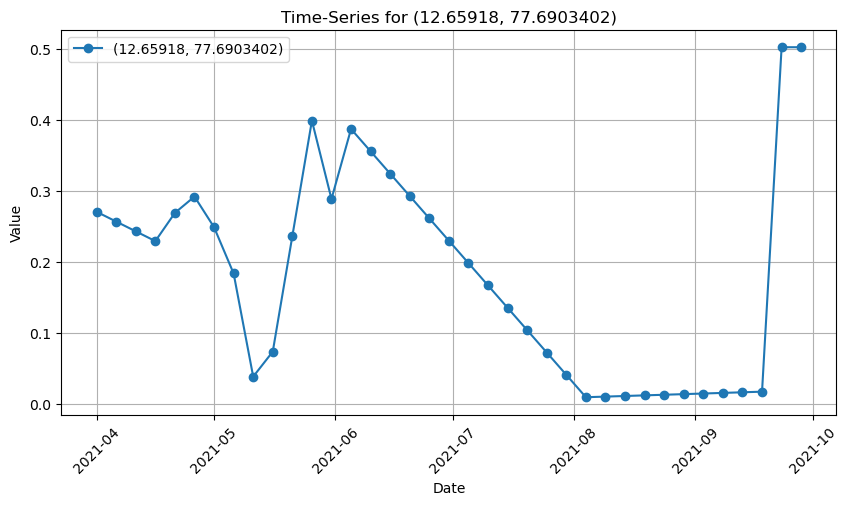

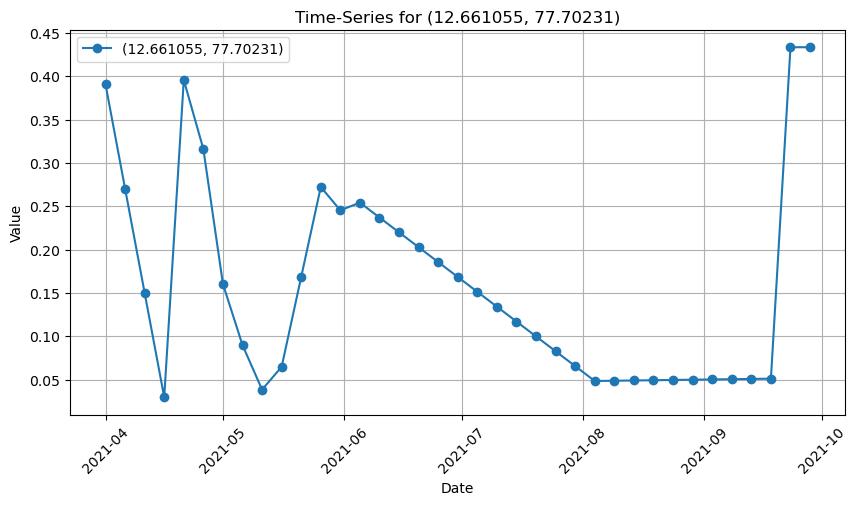

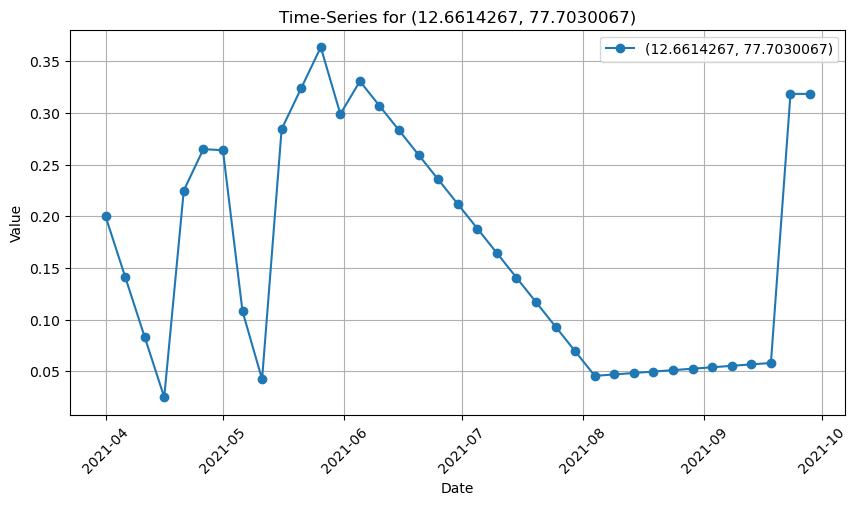

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "Karnataka_Complete_Data_5Day/Sample/NDVI_Timeseries_Multiple_Locations.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Convert date columns to datetime format
date_columns = df.columns[2:]  # Assuming first two columns are Latitude and Longitude
df[date_columns] = df[date_columns].astype(float)  # Convert values to float
date_series = pd.to_datetime(date_columns, format="%Y-%m-%d")

# Iterate over each Latitude-Longitude pair
for index, row in df.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    values = row[date_columns]  # Extract NDVI (or other values)
    
    plt.figure(figsize=(10, 5))
    plt.plot(date_series, values, marker="o", linestyle="-", label=f"({lat}, {lon})")
    
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Time-Series for ({lat}, {lon})")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Save the plot or show it
    #plt.savefig(f"plots/{lat}_{lon}.png", dpi=300, bbox_inches="tight")  # Save plot
    #plt.close()

print("All plots generated and saved in 'plots/' directory.")
